# PROJET 7: Implémentez un modèle de scoring

- L'objectif est de créer un modèle de notation pour évaluer la probabilité de défaut de paiement d'un client, afin de prendre une décision concernant l'octroi d'un prêt à un nouveau client. Les données sont fournies sous la forme de plusieurs fichiers CSV qui contiennent des informations sur les clients d'une banque.
- Le fichier "application_train" contient de nombreuses informations sur les clients qui ont déjà emprunté de l'argent, ainsi que des indications sur le remboursement ou le défaut de paiement de ces emprunts.
- Le fichier "application_test" contient les mêmes informations que le fichier "application_train", mais il sert à déterminer la probabilité de défaut de paiement pour de nouveaux emprunts.
- Les autres fichiers contiennent des informations sur des emprunts précédents accordés soit par d'autres institutions, soit par la même banque.

In [41]:
#Générale
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load 
import pylab as pl
import pickle

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split

In [2]:
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler

In [3]:
# Training data
app_train = pd.read_csv('application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Testing data features
app_test = pd.read_csv('application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Analyse Exploratoire des Données

- Colonne:'TARGET'

In [5]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [6]:
def solvability_clients(df):
    """
    Pieplot de la solvabilité clients
    df(pd.DataFrame): jeu de données
    """
    # % de valeurs 'TARGET' différentes
    target_values = df['TARGET'].value_counts()/len(df)*100
    # Pieplot du % de chaque valeurs différentes de 'TARGET'
    plt.pie(target_values,
            colors=['#2ecc71', '#e74c3c'],
            autopct='%1.1f%%',
            labels=["Remboursé", "Non remboursé"],
            startangle=90)
    plt.show()

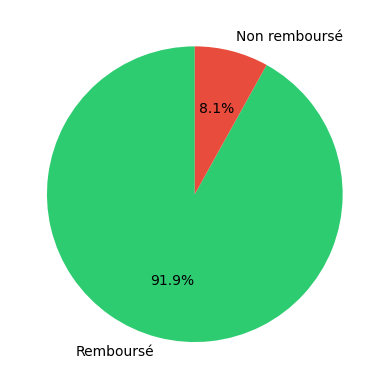

In [7]:
# Pieplot solvabilité clients du jeu d'entrainement
solvability_clients(app_train)

- #### Détection des valeurs manquantes 

In [8]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [9]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(10)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [10]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

- Variables numériques

In [11]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [12]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

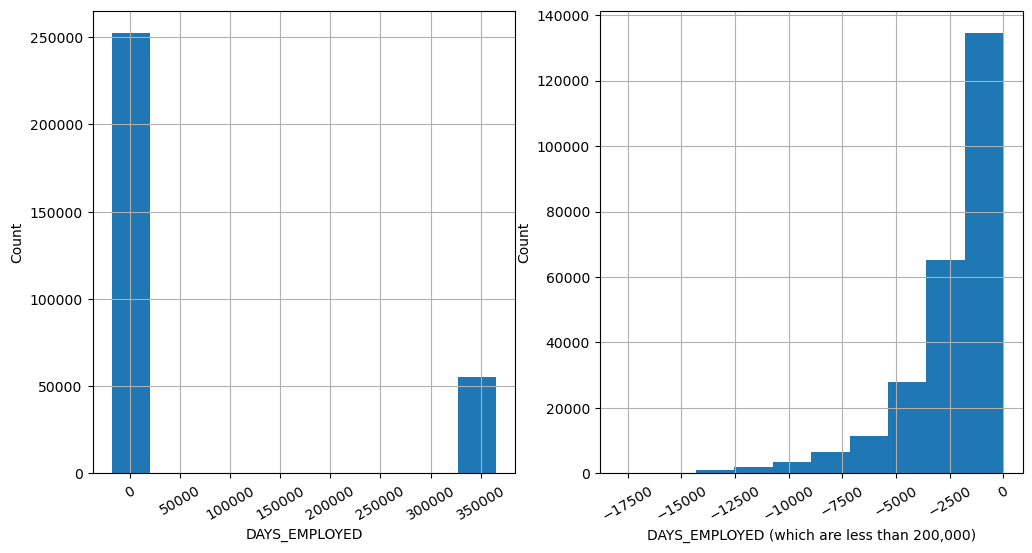

In [13]:
# Affiche l'histogramme du nombre de jours employés
fig = plt.figure(1, figsize=(12, 6))
plt.subplot(1, 2, 1)
app_train['DAYS_EMPLOYED'].hist()
plt.xlabel('DAYS_EMPLOYED')
plt.ylabel('Count')
plt.xticks(rotation=30)

# Affiche l'histogramme pour les valeurs normales
plt.subplot(1, 2, 2)
app_train.loc[app_train['DAYS_EMPLOYED'] < 200000, 'DAYS_EMPLOYED'].hist()
plt.xlabel('DAYS_EMPLOYED (which are less than 200,000)')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.show()

In [14]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


- Analyse bivariée des variables par rapport à la variable cible "TARGET".

In [15]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


**Corrélation de pearson**

In [16]:
def heatmap_pearson(frame,v_max,v_min,v_centre):

  final_data_pears=frame.corr(method='pearson')
  #coupe en deux le heatmap
  mask = np.triu(np.ones_like(final_data_pears, dtype=np.bool_))
  f, ax = plt.subplots(figsize=(22, 22))

  # couleur
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(final_data_pears, mask=mask, cmap=cmap, vmax=v_max,vmin=v_min, center=v_centre,
              square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [17]:
col_pears=[
 'TARGET',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'REGION_RATING_CLIENT',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3'
]

train_pears=app_train[col_pears].copy()

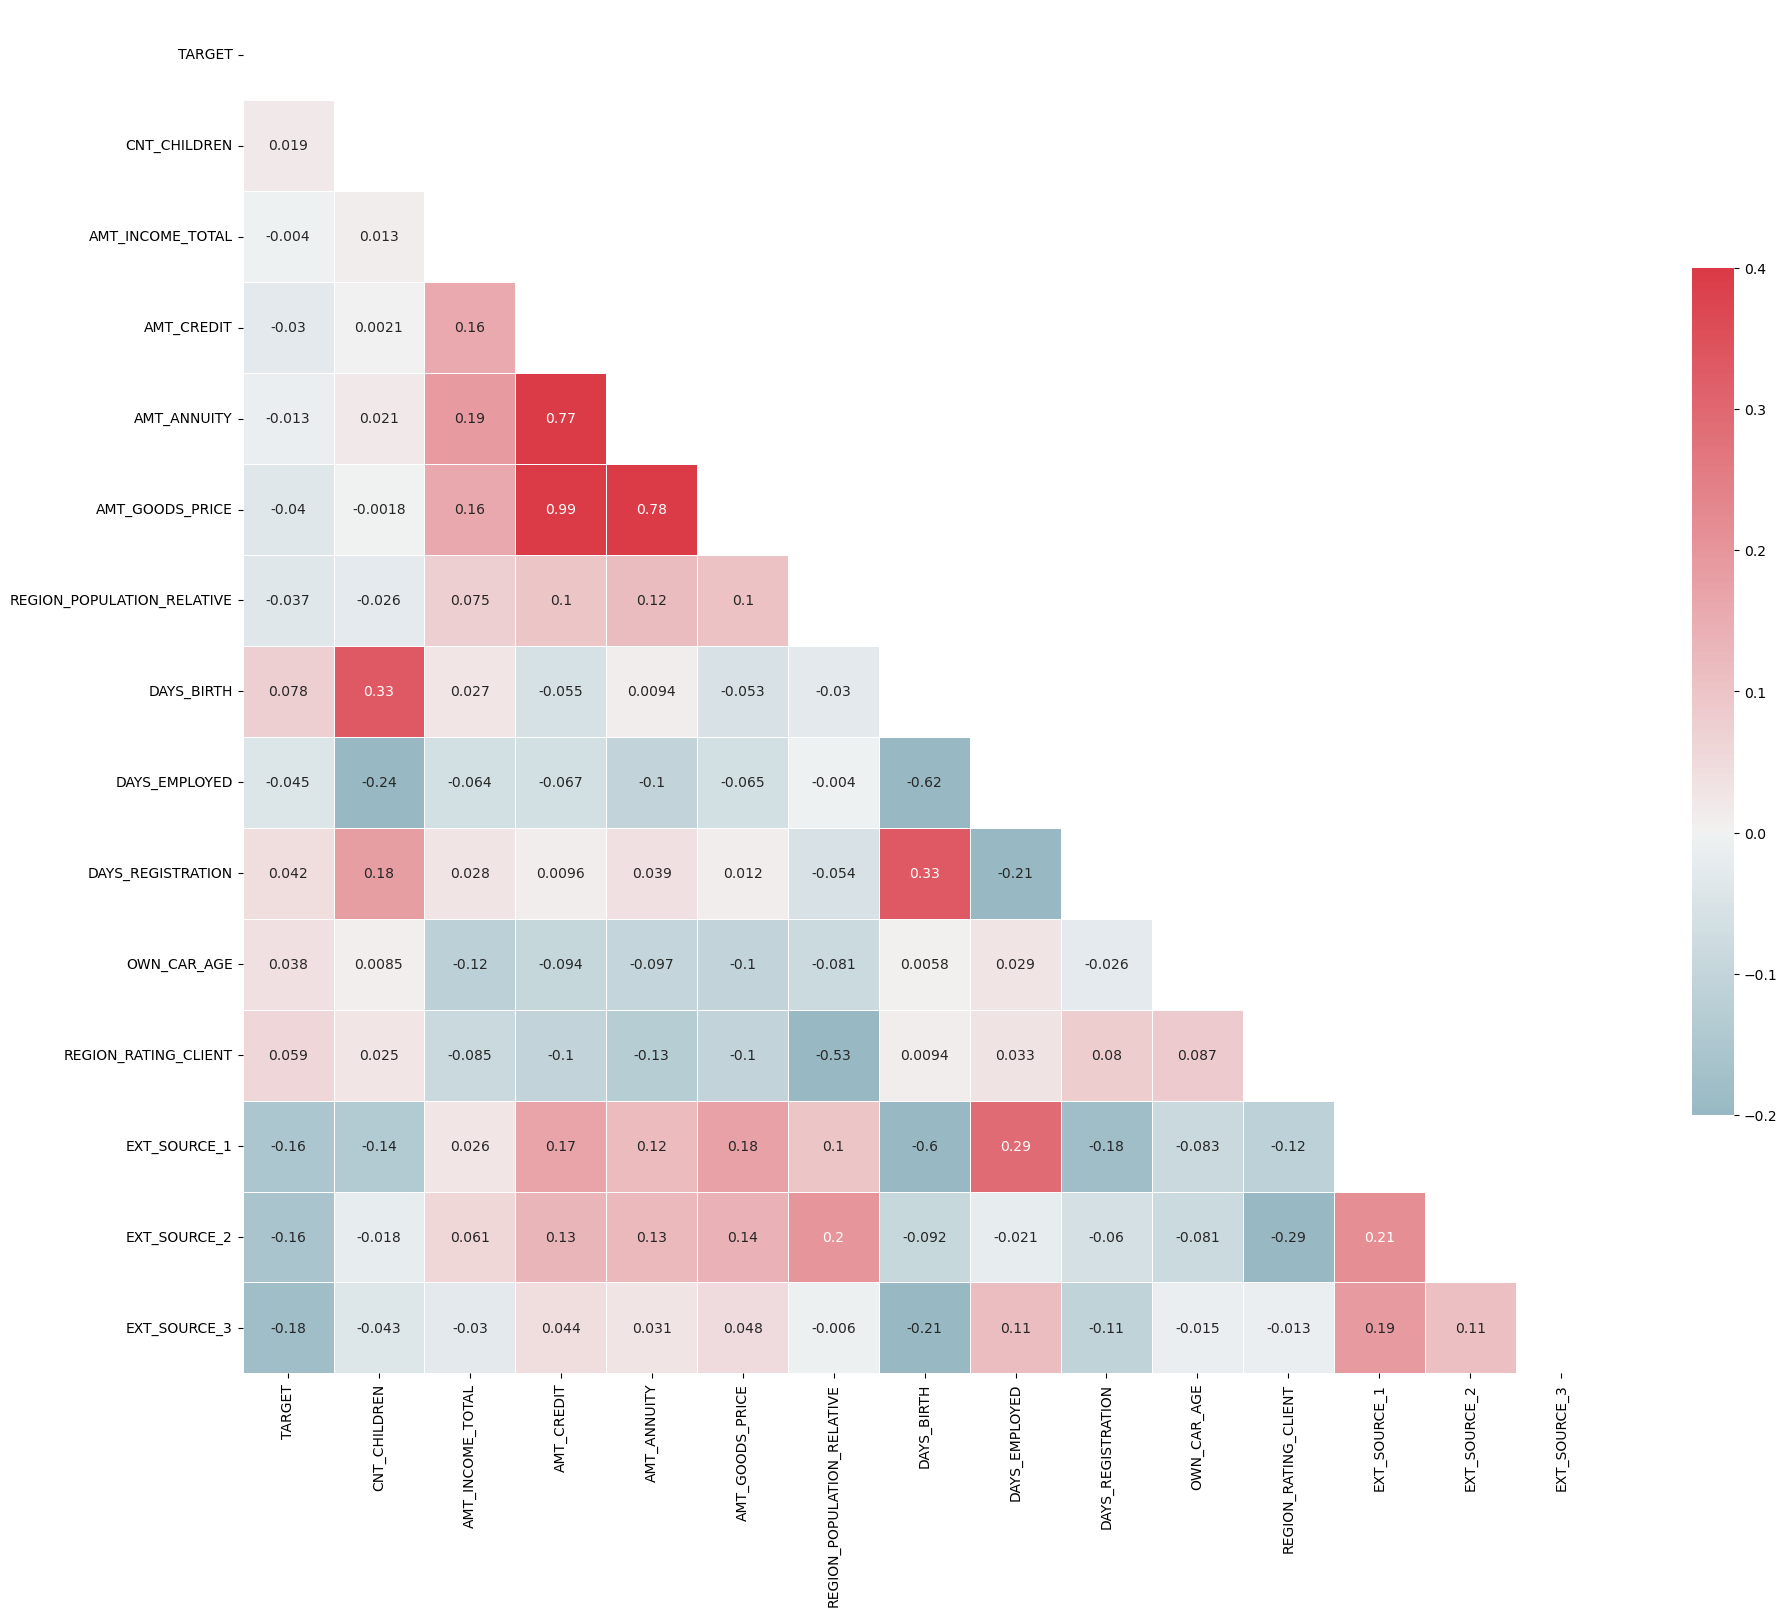

In [18]:
heatmap_pearson(train_pears,0.4,-0.2,0)

**Effet de l'âge sur le remboursement**

In [19]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982703

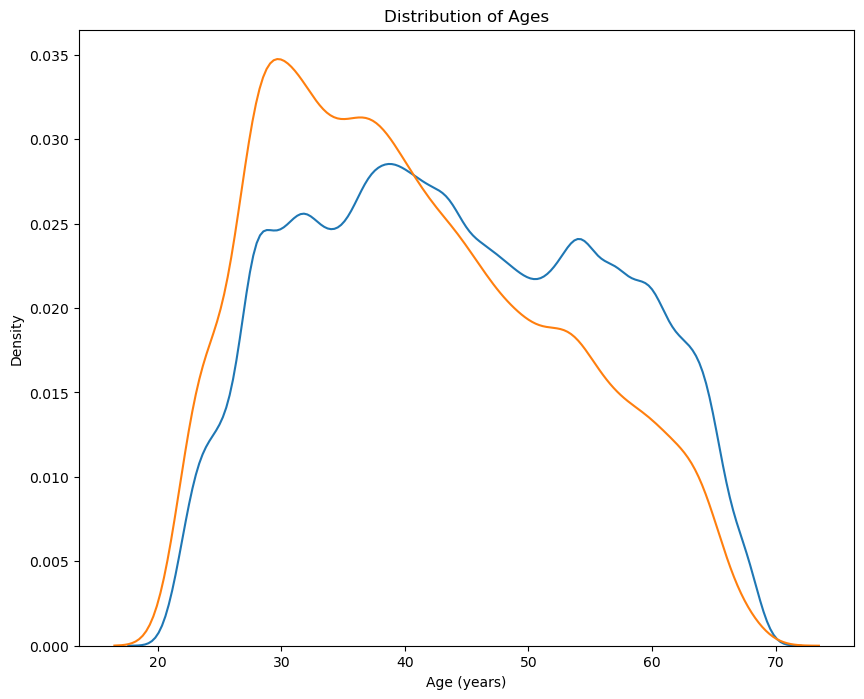

In [20]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [21]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [22]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


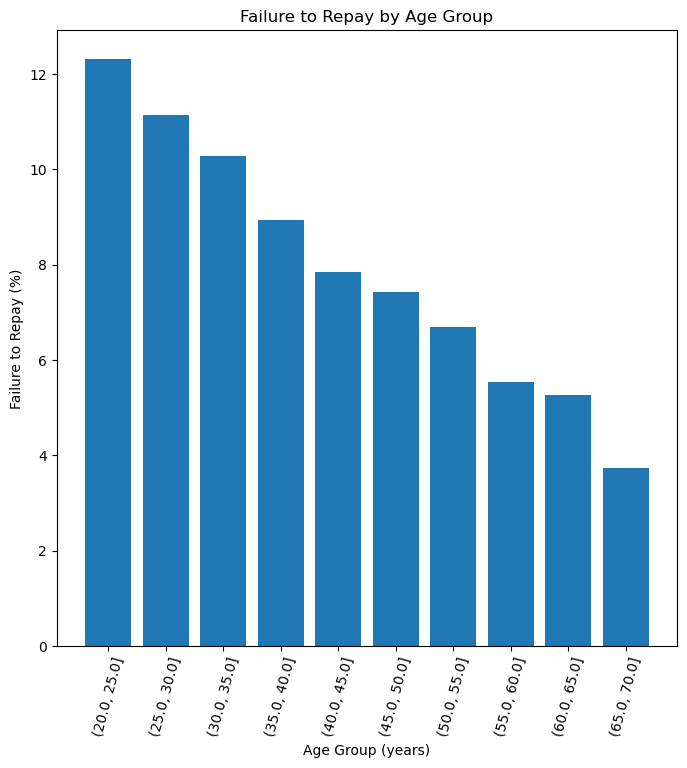

In [23]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

## Feature Engineering Train et Test

In [24]:
# Training data
app_train = pd.read_csv('application_train.csv')
print('Training data shape: ', app_train.shape)


# Testing data features
app_test = pd.read_csv('application_test.csv')
print('Testing data shape: ', app_test.shape)

Training data shape:  (307511, 122)
Testing data shape:  (48744, 121)


In [25]:
### FONCTION POUR NETTOYER ET ENCODER LES DATAS


def clean_data(train, test, encoding = 'ohe'):

    # Valeurs abérantes
    train['DAYS_EMPLOYED_ANOM'] = train["DAYS_EMPLOYED"] == 365243
    test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243

    train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
    test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

    #Création de feature
    app_train_domain = train.copy()
    app_test_domain = test.copy()

    app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
    app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
    app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
    app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

    app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
    app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
    app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
    app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

    features=app_train_domain.copy()
    test_features=app_test_domain.copy()

    # Extraction des ID
    train_ids = features['SK_ID_CURR'] 
    test_ids = test_features['SK_ID_CURR'] 
    
    # Extraction des Targets
    labels = features['TARGET']
   
    # Suppression des ID and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])

    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Alignement des dataframes 
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # label encoding
    elif encoding == 'le':
        
        # Creation du label encoder
        label_encoder = LabelEncoder()
        
        # Liste de stock indices
        cat_indices = []
        
        #Encodage
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                cat_indices.append(i)

    # Extraction des noms des Feature
    feat_name = list(features.columns)

    #Imputation des Nan 
    imputer = SimpleImputer(strategy = 'median')

    features = imputer.fit_transform(features)
    test_features = imputer.transform(test_features)

    # Scale les features
    scaler = MinMaxScaler(feature_range = (0, 1))

    features = scaler.fit_transform(features)
    test_features = scaler.transform(test_features)

    # Création des dataset
    features_set=pd.DataFrame(features,columns=feat_name)
    test_features_set=pd.DataFrame(test_features,columns=feat_name)

    # récupération des ID
    features_set['SK_ID_CURR']=train_ids
    test_features_set['SK_ID_CURR']=test_ids 
    
    # récupération des Targets
    features_set['TARGET']=labels

    print('Training Data Shape: ', features_set.shape)
    print('Testing Data Shape: ', test_features_set.shape)
    
    return features_set, test_features_set

In [26]:
train_set, test_set= clean_data(app_train, app_test, encoding = 'ohe')

Training Data Shape:  (307511, 248)
Testing Data Shape:  (48744, 247)


In [27]:
pickle.dump( train_set, open( "set_train.p", "wb" ) )
pickle.dump( test_set, open( "set_test.p", "wb" ) )

In [28]:
train_set = pickle.load( open( "set_train.p", "rb" ) )
test_set = pickle.load( open( "set_test.p", "rb" ) )

### Préparation de l’environnement d’expérimentation MLFlow

In [29]:
pip install pyngrok

Note: you may need to restart the kernel to use updated packages.


## Modélisation

### Création de la fonction coût métier 

In [30]:
# fonction métier à partir de la matrice de confusion
def custom_metric(y_true, y_pred):
    """Fonction qui extraie de la matrice de confusion les
    valeurs des 4 mesures et retourne un calcul sur base
    d'une pondération de FP et FN"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (10*fn + fp)/len(y_true)

# un custom_auc
def custom_auc_metric(y_true, y_pred_proba):
    """Fonction qui permet d'utiliser les mêmes entrées que
    custom_metric sans utiliser y_pred mais y_proba à la place"""
    return roc_auc_score(y_true, y_pred_proba)

In [31]:
# creation du custom_score métier sur base du custom_metric pour guider le GridsearchCV
from sklearn.metrics import fbeta_score, make_scorer, auc
custom_score = make_scorer(custom_metric, greater_is_better=False)

In [32]:
# creation du custom_auc sur base du custom_auc_metric
custom_auc = make_scorer(custom_auc_metric, greater_is_better=True, needs_proba=True)

In [32]:
#métrique principale
scores = {'custom_score': custom_score}

#### Confusion Matrix and ROC Area Under the Curve

In [33]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, dataset):
    '''This function will make a pretty plot of a
    sklearn Confusion Matrix using a 
    Seaborn heatmap visualization + ROC Curve.'''
    
    # global indices
    fig = plt.figure(figsize=(10, 10))
    
    # plot Confusion Matrix
    plt.subplot(221)
    
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(
        value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(
        group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    
    # plot Area Under the Curve (ROC)
    plt.subplot(222)
    
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    # plot no-skill curve
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='No Skill')
    # plot the ROC_AUC curve
    if dataset=="train":
        plt.plot(fpr, tpr, color='orange', linewidth=5,
             label='ROC_AUC (train) = %0.4f' %roc_auc1)
    elif dataset=="test":
        plt.plot(fpr, tpr, color='orange', linewidth=5,
             label='ROC_AUC (test) = %0.4f' %roc_auc2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()

    
    # plot Area Under the Curve (Precision-Recall)
    plt.subplot(212)
    # predict class values
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    no_skill = len(y_true[y_true==1]) / len(y_true)
    # plot no-skill curve
    plt.plot([0, 1], [no_skill, no_skill], color='darkblue', linestyle='--', label='No Skill')
    # calculate precision-recall AUC
    pr_auc = auc(recall, precision)
    # plot the precision-recall curves
    if dataset=="train":
        plt.plot(recall, precision, color='orange', linewidth=5,
             label='PR_AUC (train) = %0.4f' %pr_auc)
    elif dataset=="test":
        plt.plot(recall, precision, color='orange', linewidth=5,
             label='PR_AUC (test) = %0.4f' %pr_auc)    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    
    # show the plot   
    plt.show()

### Model Comparison | Confusion Matrix and ROC / PR AUC curves

In [34]:
model_names = ["Dummy", "LogReg", "RandFor", "XGBC"]

In [35]:
def cf_matrix_compare(dataset):
    '''This function will make plot of
    Confusion Matrixes using a 
    Seaborn heatmap visualization
    for all models trained / tested.'''
    
    # global indices
    group_names = ['No Default', 'Default']
    fig, axs = plt.subplots(1, 4, figsize=(25, 5), sharey='row')
    fig.set_facecolor('lightgrey')
        
    for i, model in enumerate(model_names):
        # plot Confusion Matrixes | axs[row, col]
        if dataset=="train":
            cf_matrix = confusion_matrix(y_train, predictions_1[i])
            fig.text(0.4, 0.1, 'Predicted label (train)', ha='left')
        elif dataset=="test":
            cf_matrix = confusion_matrix(y_test, predictions_2[i])
            fig.text(0.4, 0.1, 'Predicted label (test)', ha='left')

        disp = ConfusionMatrixDisplay(cf_matrix,
                                      display_labels=group_names)

        disp.plot(ax=axs[i], xticks_rotation=45)
        disp.ax_.set_title(model)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        axs[i].grid(False)
        if i!=0:
            disp.ax_.set_ylabel('')

    plt.subplots_adjust(wspace=0.40, hspace=0.1)
    
    fig.colorbar(disp.im_, ax=axs)
    plt.show()

In [36]:
def auc_compare(dataset):
    '''This function will make plot of a
    ROC and PR Curves of all models tested,
    and return PR_AUC values.'''
    
    # global indices
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    col = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    # instantiate dictionaries
    pr_auc_val_train=[]
    pr_auc_val_test=[]
    
    # plot Area Under the Curve (ROC)
    plt.subplot(121)
    
    for i, model in enumerate(model_names):
        # plot ROC_AUC curves
        if dataset=="train":
            fpr, tpr, _ = roc_curve(y_train, pred_proba_1[i])
            plt.plot(fpr, tpr, color=col[i], linewidth=4, label=f"{model}AUC (train) = {round(roc_auc_1[i], 4)}")
        elif dataset=="test":
            fpr, tpr, _ = roc_curve(y_test, pred_proba_2[i])
            plt.plot(fpr, tpr, color=col[i], linewidth=4, label=f"{model}AUC (test) = {round(roc_auc_2[i], 4)}")
  
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
        
    # plot Area Under the Curve (Precision-Recall)
    plt.subplot(122)
   
    for i, model in enumerate(model_names):
    # predict class values
        if dataset=="train":
            precision, recall, _ = precision_recall_curve(y_train, pred_proba_1[i])
            # calculate precision-recall AUC
            pr_auc = auc(recall, precision)
            # add pr_auc value to list for the final presentation dataframe 
            pr_auc_val_train.append(pr_auc)
            # plot the precision-recall curves
            plt.plot(recall, precision, color=col[i], linewidth=4,
                     label=f"{model}PR_AUC (train) = {round(pr_auc, 4)}")
            
        elif dataset=="test":
            precision, recall, _ = precision_recall_curve(y_test, pred_proba_2[i])
            # calculate precision-recall AUC
            pr_auc = auc(recall, precision)
            # add pr_auc value to list for the final presentation dataframe 
            pr_auc_val_test.append(pr_auc)
            # plot the precision-recall curves
            plt.plot(recall, precision, color=col[i], linewidth=4,
                     label=f"{model}PR_AUC (test) = {round(pr_auc, 4)}")

    no_skill = len(y_train[y_train==1]) / len(y_train)
    # plot no-skill curve
    plt.plot([0, 1], [no_skill, no_skill], color='darkblue', linestyle='--', label='No Skill')
    
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    
    plt.show()
    
    return pr_auc_val_train, pr_auc_val_test

In [37]:
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':15,
     'ytick.labelsize':15,
     'axes.labelsize': 15,
     'legend.fontsize': 15,
     'axes.titlesize':15,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

In [38]:
# Modification des affichages de colonnes, lignes et largeurs de colonnes pour bien visualiser les colonnes
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

# Format des graphiques seaborn
sns.set_theme(style="whitegrid")

In [39]:
X = train_set.drop(columns=["TARGET"])
y = train_set["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [41]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))
print(y.value_counts(normalize=True))

0    0.919271
1    0.080729
Name: TARGET, dtype: float64
0    0.919272
1    0.080728
Name: TARGET, dtype: float64
0    0.919271
1    0.080729
Name: TARGET, dtype: float64


In [42]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((246008, 247), (61503, 247), (246008,), (61503,))

In [43]:
X_train.rename(columns = {'NAME_EDUCATION_TYPE_Secondary / secondary special':\
                         'NAME_EDUCATION_TYPE_Secondary_secondary special'}, inplace = True)

In [44]:
X_test.rename(columns = {'NAME_EDUCATION_TYPE_Secondary / secondary special':\
                         'NAME_EDUCATION_TYPE_Secondary_secondary special'}, inplace = True)

In [45]:
# on copie X_test
data = X_test.copy()
# on ajoute la target pour vérification
data["TARGET"] = y_test

In [46]:
data.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,...,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: typ

In [47]:
import pickle
import joblib
# preparation for SHAP feature importance
# reduce test dataset to 10 000 observations
# initial dataset too heavy to be loaded on GitHub too

# Backup sample X_test
joblib.dump(X_test.iloc[0:10000,:], 'Models/X_test.pkl')

# Backup sample y_test
joblib.dump(y_test[0:10000], 'Models/y_test.pkl')

['Models/y_test.pkl']

In [48]:
# Création d'un dataframe pour visaliser les scores selon le modèle utilisé
data_type = pd.Series(['Train', 'Test', 'Train', 'Test', 'Train', 'Test', 'Train','Test'])

data_model = pd.Series(['Dummy', 'Dummy', 'LogReg', 'LogReg', 'RandFor', 'RandFor','XGBC', 'XGBC'])

frame = {'Data': data_type, 'Model': data_model,
         'Custom_score': '', 'ROC_AUC': '', 'PR_AUC': ''}

model_scores = pd.DataFrame(frame)
model_scores

,Data,Model,Custom_score,ROC_AUC,PR_AUC
0,Train,Dummy,,,
1,Test,Dummy,,,
2,Train,LogReg,,,
3,Test,LogReg,,,
4,Train,RandFor,,,
5,Test,RandFor,,,
6,Train,XGBC,,,
7,Test,XGBC,,,


#### Baseline - Dummy Classifier

In [49]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [50]:
dummy_clf = DummyClassifier(strategy='most_frequent',
                            random_state=42)
dummy_clf.fit(X_train, y_train)

DummyClassifier(random_state=42, strategy='most_frequent')

In [51]:
from sklearn.dummy import DummyClassifier

# Créer une instance du DummyClassifier
dummy_clf = DummyClassifier()

# Ajuster le modèle aux données d'entraînement
dummy_clf.fit(X_train, y_train)

# Maintenant, vous pouvez utiliser la méthode predict_proba
y_pred_proba1 = dummy_clf.predict_proba(X_train)[:, 1]

In [52]:
import mlflow
# Définition d'une expérience (Une expérience peut contenir plusieurs *runs*)
mlflow.set_experiment("DummyClassifier")
mlflow.sklearn.autolog() # Ici on fait appel à l'API MLflow qui intégre les algos de Scikit-Learn.
                        # C'est grâce à ce code qu'on enregistre toutes les métriques et métadonnées de cette expérience (Module MLflow Tracking)
with mlflow.start_run(run_name = 'DummyClassifier'):
  clf1 = DummyClassifier()
  clf1.fit(X_train, y_train)
  # Effectuer les prédictions sur les données de test
  y_pred = clf1.predict(X_test)
  y_pred_proba1 = clf1.predict_proba(X_train)[:, 1]

2023/07/20 17:28:16 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/60/hb75r86s6q32cwlq2m29fbkm0000gn/T/tmpp1fkjlyx/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.2.2', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.


In [53]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import fbeta_score, make_scorer, auc
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import get_scorer_names

In [54]:
from tqdm import tqdm
# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba1 = dummy_clf.predict_proba(X_train)[:, 1]

# on n'utilise pas les prédictions du modèle,
# mais celles dérivées des probabilités optimisées
# y_pred1 = dummy_clf.predict(X_train)

# optimisation sur le jeu d'entrainement
best_thresh = None
best_custom_score = 1
for thresh in tqdm(np.linspace(0, 1, 100)):
    custom_score = custom_metric(y_train, y_pred_proba1>thresh)
    if custom_score < best_custom_score:
        print(thresh)
        best_thresh = thresh
        best_custom_score = custom_score
        
# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
y_pred1 = dummy_clf.predict_proba(X_train)[:, 1]>best_thresh

roc_auc1 = roc_auc_score(y_train, y_pred_proba1)
# Measure of the custom_score from truthful and predicted values
custom_metric1 = custom_metric(y_train, y_pred1)

 12%|█████                                     | 12/100 [00:00<00:01, 56.84it/s]

0.0
0.08080808080808081


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 62.84it/s]


In [55]:
confusion_matrix(y_train, y_pred1)

array([[226148,      0],
       [ 19860,      0]])

In [56]:
best_thresh

0.08080808080808081

In [57]:
best_custom_score

0.8072908198107379

In [58]:
print('AUC_train : %0.4f' % roc_auc1)
print('custom_score_train : %0.4f' % custom_metric1)
print(classification_report(y_train, y_pred1))

AUC_train : 0.5000
custom_score_train : 0.8073
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    226148
           1       0.00      0.00      0.00     19860

    accuracy                           0.92    246008
   macro avg       0.46      0.50      0.48    246008
weighted avg       0.85      0.92      0.88    246008



 ##### Predict / Test

In [59]:
# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba2 = dummy_clf.predict_proba(X_test)[:, 1]

# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
# y_pred2 = grid.predict(X_test)
y_pred2 = dummy_clf.predict_proba(X_test)[:, 1]>best_thresh

roc_auc2 = roc_auc_score(y_test, y_pred_proba2)
# Measure of the custom_score from truthful and predicted values
custom_metric2 = custom_metric(y_test, y_pred2)

In [60]:
print('AUC_test : %0.4f' % roc_auc2)
print('custom_score_test : %0.4f' % custom_metric2)
print(classification_report(y_test, y_pred2))

AUC_test : 0.5000
custom_score_test : 0.8073
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



##### AUC du fichier train “cross-validé” | choix meilleur modèle

In [61]:
# vérif calcul custom_score
FN=19860
FP=0
indiv_train=246005
Verif_CS_Dummy = (FP+10*FN)/(10*indiv_train)

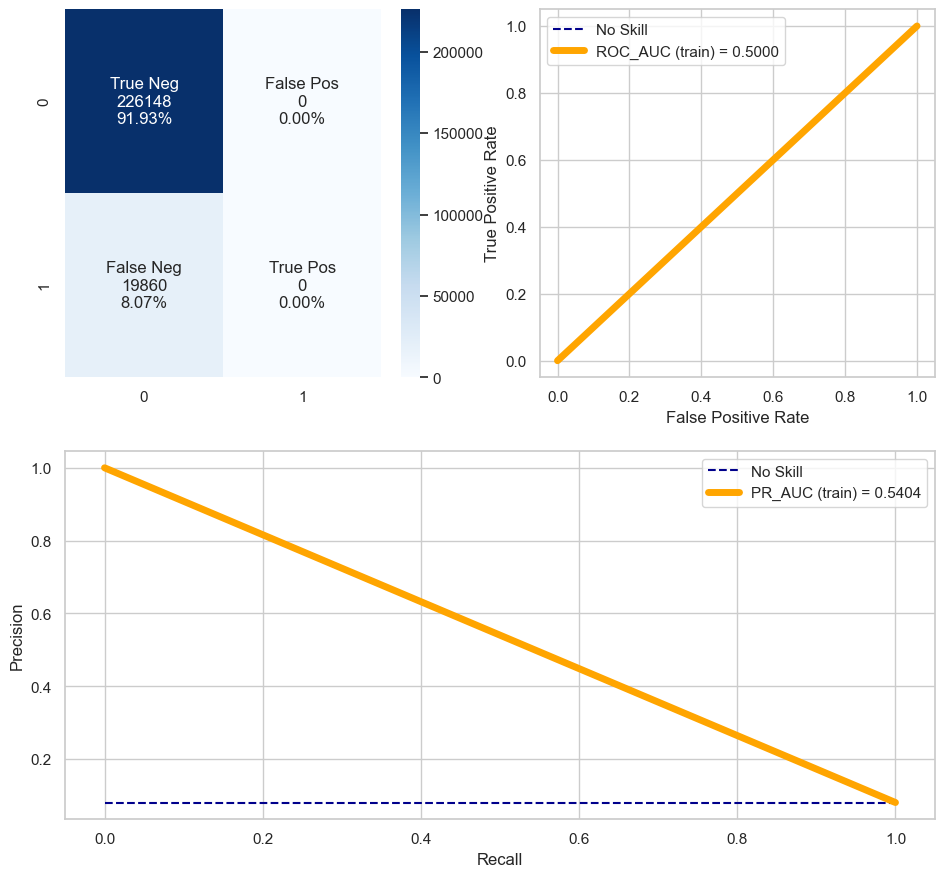

In [62]:
cf_matrix_roc_auc(dummy_clf, y_train, y_pred1, y_pred_proba1, "train")

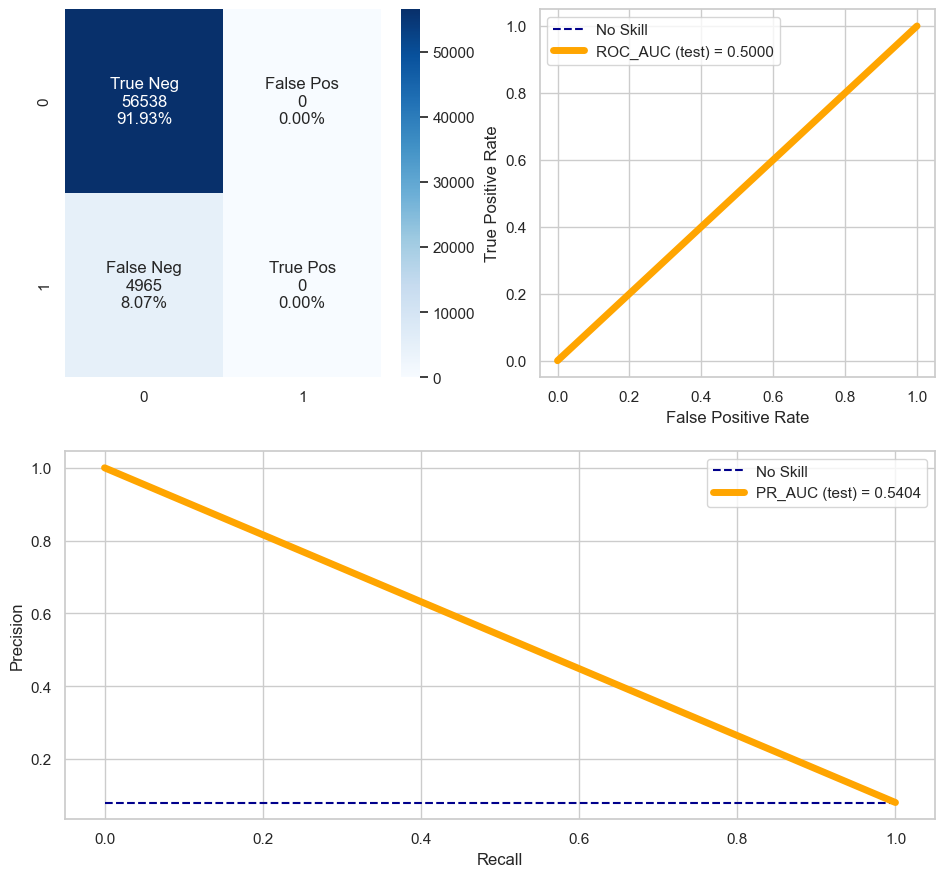

In [63]:
#AUC du fichier test | contrôle de cohérence
cf_matrix_roc_auc(dummy_clf, y_test, y_pred2, y_pred_proba2, "test")

In [64]:
# Mise à jour des résultats / Train
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='Dummy'),'Custom_score'] = round(custom_metric1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='Dummy'),'ROC_AUC'] = round(roc_auc1,4)

In [65]:
# Mise à jour des résultats / Test
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='Dummy'),'Custom_score'] = round(custom_metric2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='Dummy'),'ROC_AUC'] = round(roc_auc2,4)

In [66]:
#On conserve ces résultats pour un graphique comparatif
Dummy_y_pred1, Dummy_y_pred_proba1, Dummy_y_pred2, Dummy_y_pred_proba2, Dummy_roc_auc1, Dummy_roc_auc2 =\
y_pred1, y_pred_proba1, y_pred2, y_pred_proba2, roc_auc1, roc_auc2

In [67]:
model_scores

,Data,Model,Custom_score,ROC_AUC,PR_AUC
0,Train,Dummy,0.8073,0.5,
1,Test,Dummy,0.8073,0.5,
2,Train,LogReg,,,
3,Test,LogReg,,,
4,Train,RandFor,,,
5,Test,RandFor,,,
6,Train,XGBC,,,
7,Test,XGBC,,,


#### Logistic Regression

In [68]:
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [69]:
model = imbpipeline(steps = [["impute", SimpleImputer(missing_values=np.nan, strategy='mean')],
                             ['smote', SMOTE(random_state=42)],
                             ['scaler', StandardScaler()],
                             ['classifier', LogisticRegression(random_state=42,
                                                                  max_iter=1000)]])

In [70]:
model

Pipeline(steps=[['impute', SimpleImputer()], ['smote', SMOTE(random_state=42)],
                ['scaler', StandardScaler()],
                ['classifier',
                 LogisticRegression(max_iter=1000, random_state=42)]])

In [71]:
import mlflow
# Définition d'une expérience (Une expérience peut contenir plusieurs *runs*)
mlflow.set_experiment("LogisticRegression(")
mlflow.sklearn.autolog() # Ici on fait appel à l'API MLflow qui intégre les algos de Scikit-Learn.
                        # C'est grâce à ce code qu'on enregistre toutes les métriques et métadonnées de cette expérience (Module MLflow Tracking)
with mlflow.start_run(run_name = 'LogisticRegression'):
  clf2 = LogisticRegression()
  clf2.fit(X_train, y_train)
  # Effectuer les prédictions sur les données de test
  y_pred1 = clf2.predict(X_test)
  y_pred_proba2 = clf2.predict_proba(X_train)[:, 1]

In [72]:
param_grid = {}

In [73]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [74]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)

In [75]:
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    scoring=scores,
                    cv=stratified_kfold,
                    refit='custom_score',
                    verbose=2,
                    return_train_score=True,
                    n_jobs=1)

In [76]:
grid.fit(X_train, y_train)

2023/07/20 17:29:07 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f1f497f0e1314057b2528a8ff0aa32ba', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .................................................... total time=  27.2s
[CV] END .................................................... total time=  27.8s
[CV] END .................................................... total time=  34.9s


2023/07/20 17:31:51 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[['impute', SimpleImputer()],
                                       ['smote', SMOTE(random_state=42)],
                                       ['scaler', StandardScaler()],
                                       ['classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42)]]),
             n_jobs=1, param_grid={}, refit='custom_score',
             return_train_score=True,
             scoring={'custom_score': make_scorer(custom_metric, greater_is_better=False)},
             verbose=2)

In [77]:
#Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba1 = grid.predict_proba(X_train)[:, 1]

# on n'utilise pas les prédictions du modèle,
# mais celles dérivées des probabilités optimisées
# y_pred1 = grid.predict(X_train)

# optimisation sur le jeu d'entrainement
best_thresh = None
best_custom_score = 1
for thresh in tqdm(np.linspace(0, 1, 100)):
    custom_score = custom_metric(y_train, y_pred_proba1>thresh)
    if custom_score < best_custom_score:
        print(thresh)
        best_thresh = thresh
        best_custom_score = custom_score
        
# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
y_pred1 = y_pred_proba1>best_thresh

roc_auc1 = roc_auc_score(y_train, y_pred_proba1)
# Measure of the custom_score from truthful and predicted values
custom_metric1 = custom_metric(y_train, y_pred1)

  7%|███                                        | 7/100 [00:00<00:01, 62.36it/s]

0.0
0.010101010101010102
0.020202020202020204
0.030303030303030304
0.04040404040404041
0.05050505050505051
0.06060606060606061
0.07070707070707072
0.08080808080808081
0.09090909090909091
0.10101010101010102
0.11111111111111112
0.12121212121212122


 21%|████████▊                                 | 21/100 [00:00<00:01, 58.35it/s]

0.13131313131313133
0.14141414141414144
0.15151515151515152
0.16161616161616163
0.17171717171717174
0.18181818181818182
0.19191919191919193
0.20202020202020204
0.21212121212121213
0.22222222222222224
0.23232323232323235


 33%|█████████████▊                            | 33/100 [00:00<00:01, 54.17it/s]

0.24242424242424243
0.25252525252525254
0.26262626262626265
0.27272727272727276
0.2828282828282829
0.29292929292929293
0.30303030303030304
0.31313131313131315
0.32323232323232326
0.33333333333333337
0.3434343434343435


 45%|██████████████████▉                       | 45/100 [00:00<00:01, 52.45it/s]

0.3535353535353536
0.36363636363636365
0.37373737373737376
0.38383838383838387
0.393939393939394
0.4040404040404041
0.4141414141414142
0.42424242424242425
0.43434343434343436
0.4444444444444445
0.4545454545454546


 57%|███████████████████████▉                  | 57/100 [00:01<00:00, 52.73it/s]

0.4646464646464647
0.4747474747474748
0.48484848484848486
0.494949494949495
0.5050505050505051
0.5151515151515152
0.5252525252525253


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 56.64it/s]


In [78]:
confusion_matrix(y_train, y_pred1)

array([[164046,  62102],
       [  7035,  12825]])

In [79]:
best_thresh

0.5252525252525253

In [80]:
best_custom_score

0.5384052551136549

In [81]:
print('AUC_train : %0.4f' % roc_auc1)
print('custom_score_train : %0.4f' % custom_metric1)
print(classification_report(y_train, y_pred1))

AUC_train : 0.7508
custom_score_train : 0.5384
              precision    recall  f1-score   support

           0       0.96      0.73      0.83    226148
           1       0.17      0.65      0.27     19860

    accuracy                           0.72    246008
   macro avg       0.57      0.69      0.55    246008
weighted avg       0.90      0.72      0.78    246008



In [82]:
# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba2 = grid.predict_proba(X_test)[:, 1]

# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
# y_pred2 = grid.predict(X_test)
y_pred2 = grid.predict_proba(X_test)[:, 1]>best_thresh

roc_auc2 = roc_auc_score(y_test, y_pred_proba2)
# Measure of the custom_score from truthful and predicted values
custom_metric2 = custom_metric(y_test, y_pred2)

In [83]:
print('AUC_test : %0.4f' % roc_auc2)
print('custom_score_test : %0.4f' % custom_metric2)
print(classification_report(y_test, y_pred2))

AUC_test : 0.7503
custom_score_test : 0.5374
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     56538
           1       0.17      0.64      0.27      4965

    accuracy                           0.72     61503
   macro avg       0.57      0.69      0.55     61503
weighted avg       0.90      0.72      0.78     61503



#### AUC du fichier train “cross-validé” | choix meilleur modèle

In [84]:
# vérif calcul custom_score
FN=6597
FP=68759
indiv_train=246005
Verif_CS_LogReg = (FP+10*FN)/(10*indiv_train)

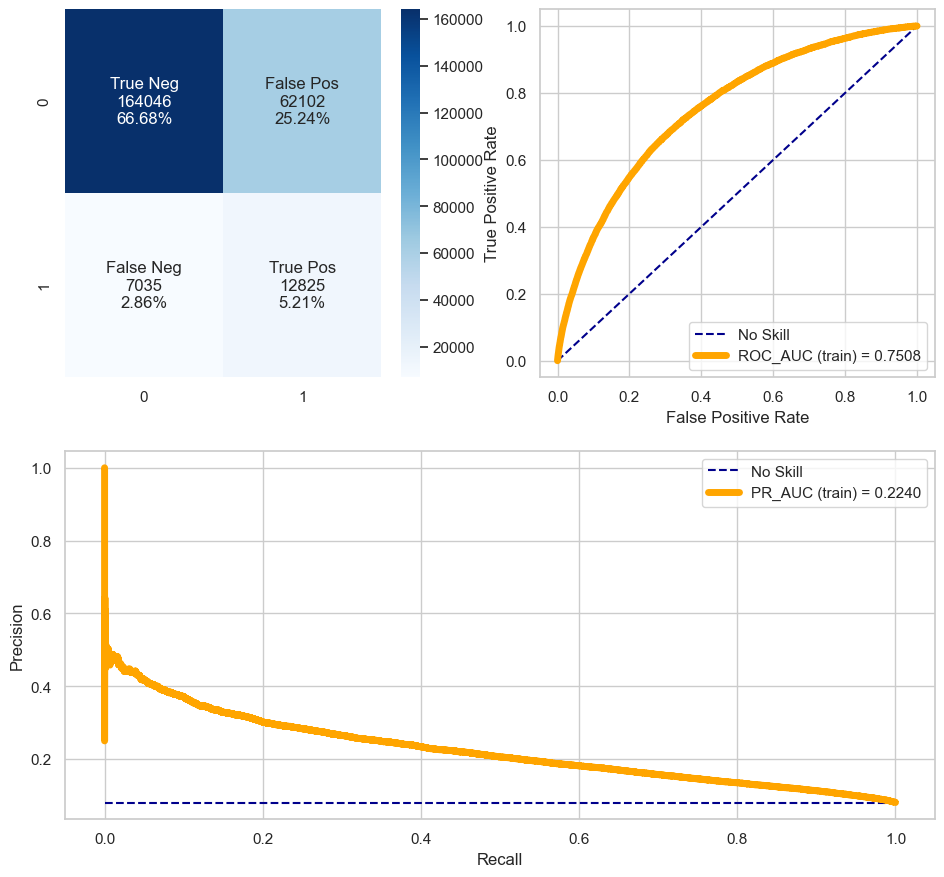

In [85]:
cf_matrix_roc_auc(grid, y_train, y_pred1, y_pred_proba1, "train")

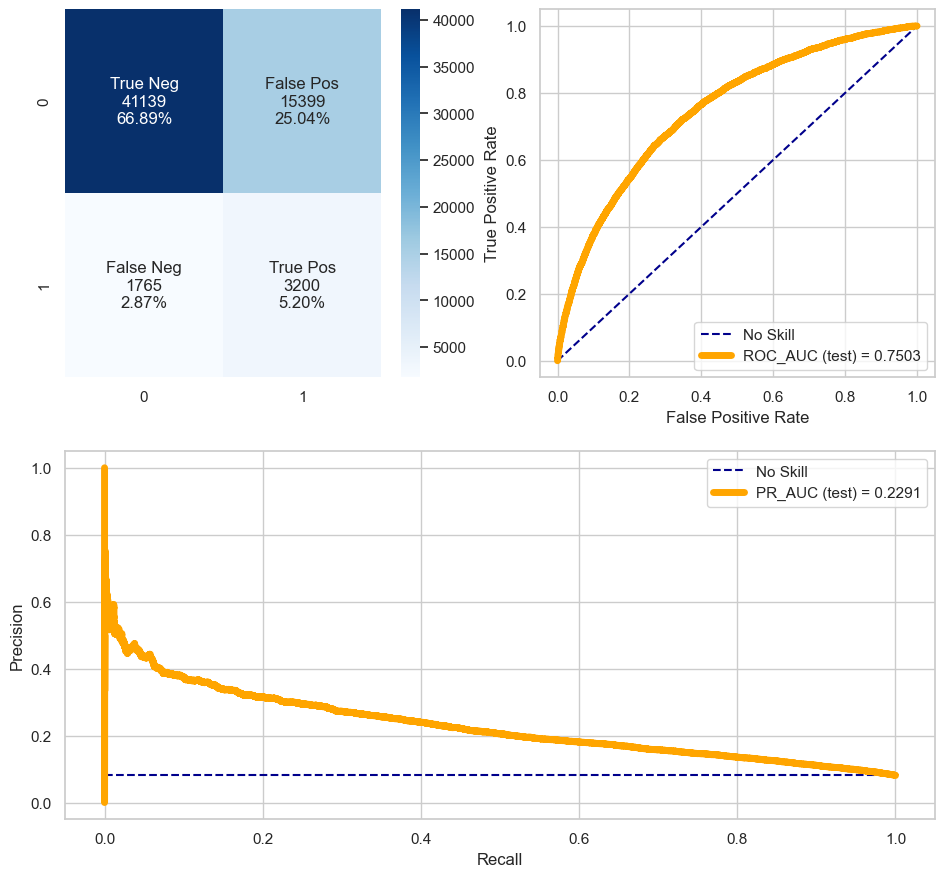

In [86]:
#AUC du fichier test | contrôle de cohérence

cf_matrix_roc_auc(grid, y_test, y_pred2, y_pred_proba2, "test")

In [87]:
# Mise à jour des résultats / Train
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='LogReg'),'Custom_score'] = round(custom_metric1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='LogReg'),'ROC_AUC'] = round(roc_auc1,4)

In [88]:
# Mise à jour des résultats / Test
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='LogReg'),'Custom_score'] = round(custom_metric2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='LogReg'),'ROC_AUC'] = round(roc_auc2,4)

In [89]:
# On conserve ces résultats pour un graphique comparatif
LogReg_y_pred1, LogReg_y_pred_proba1, LogReg_y_pred2, LogReg_y_pred_proba2, LogReg_roc_auc1, LogReg_roc_auc2 =\
y_pred1, y_pred_proba1, y_pred2, y_pred_proba2, roc_auc1, roc_auc2

In [90]:
model_scores

,Data,Model,Custom_score,ROC_AUC,PR_AUC
0,Train,Dummy,0.8073,0.5,
1,Test,Dummy,0.8073,0.5,
2,Train,LogReg,0.5384,0.7508,
3,Test,LogReg,0.5374,0.7503,
4,Train,RandFor,,,
5,Test,RandFor,,,
6,Train,XGBC,,,
7,Test,XGBC,,,


In [91]:
grid.best_estimator_

Pipeline(steps=[('impute', SimpleImputer()), ('smote', SMOTE(random_state=42)),
                ('scaler', StandardScaler()),
                ['classifier',
                 LogisticRegression(max_iter=1000, random_state=42)]])

In [92]:
import joblib
joblib.dump(grid.best_estimator_, 'Models/best_model_LogReg.joblib')
# model = joblib.load('Models/best_model_LogReg.joblib') to load it back

['Models/best_model_LogReg.joblib']

#### Random Forest Classifier

In [93]:
model = imbpipeline(steps = [["impute", SimpleImputer(missing_values=np.nan, strategy='mean')],
                             ['smote', SMOTE(random_state=42)],
                             ['scaler', StandardScaler()],
                             ['classifier', RandomForestClassifier(random_state=42)]])

In [94]:
model

Pipeline(steps=[['impute', SimpleImputer()], ['smote', SMOTE(random_state=42)],
                ['scaler', StandardScaler()],
                ['classifier', RandomForestClassifier(random_state=42)]])

In [95]:
import mlflow
# Définition d'une expérience (Une expérience peut contenir plusieurs *runs*)
mlflow.set_experiment("RandomForestClassifier")
mlflow.sklearn.autolog() # Ici on fait appel à l'API MLflow qui intégre les algos de Scikit-Learn.
                        # C'est grâce à ce code qu'on enregistre toutes les métriques et métadonnées de cette expérience (Module MLflow Tracking)
with mlflow.start_run(run_name = 'RandomForestClassifier'):
  clf3 = RandomForestClassifier()
  clf3.fit(X_train, y_train)
  # Effectuer les prédictions sur les données de test
  y_pred2 = clf3.predict(X_test)
  y_pred_proba3 = clf3.predict_proba(X_train)[:, 1]

In [96]:
# Set hyperparamteters range

# number of trees in the random forest
n_estimators = [3, 4, 5, 6, 7] 
# number of features in consideration at every split
max_features = ['sqrt']
# minimum sample number that can be stored in a leaf node
# smaller leaves = model more prone to capturing noise in train data
min_samples_leaf = [45, 50, 55]

In [97]:
param_grid = {'classifier__n_estimators': n_estimators,
              'classifier__max_features': max_features,
              'classifier__min_samples_leaf': min_samples_leaf}

In [98]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)

In [99]:
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    scoring=scores,
                    cv=stratified_kfold,
                    refit='custom_score',
                    verbose=2,
                    return_train_score=True,
                    n_jobs=1)

In [100]:
grid.fit(X_train, y_train)

2023/07/20 15:59:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e9c3a69e3fca4ec89fb0372818f4d45e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=3; total time=   6.5s
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=3; total time=   6.4s
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=3; total time=   6.2s
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=4; total time=   7.1s
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=4; total time=   6.8s
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=4; total time=   6.9s
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=5; total time=   7.7s
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=5

2023/07/20 16:05:52 INFO mlflow.sklearn.utils: Logging the 5 best runs, 10 runs will be omitted.


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[['impute', SimpleImputer()],
                                       ['smote', SMOTE(random_state=42)],
                                       ['scaler', StandardScaler()],
                                       ['classifier',
                                        RandomForestClassifier(random_state=42)]]),
             n_jobs=1,
             param_grid={'classifier__max_features': ['sqrt'],
                         'classifier__min_samples_leaf': [45, 50, 55],
                         'classifier__n_estimators': [3, 4, 5, 6, 7]},
             refit='custom_score', return_train_score=True,
             scoring={'custom_score': make_scorer(custom_metric, greater_is_better=False)},
             verbose=2)

In [101]:
# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba1 = grid.predict_proba(X_train)[:, 1]

# on n'utilise pas les prédictions du modèle,
# mais celles dérivées des probabilités optimisées
# y_pred1 = grid.predict(X_train)

# optimisation sur le jeu d'entrainement
best_thresh = None
best_custom_score = 1
for thresh in tqdm(np.linspace(0, 1, 100)):
    custom_score = custom_metric(y_train, y_pred_proba1>thresh)
    if custom_score < best_custom_score:
        print(thresh)
        best_thresh = thresh
        best_custom_score = custom_score
        
# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
y_pred1 = y_pred_proba1>best_thresh

roc_auc1 = roc_auc_score(y_train, y_pred_proba1)
# Measure of the custom_score from truthful and predicted values
custom_metric1 = custom_metric(y_train, y_pred1)

 12%|█████                                     | 12/100 [00:00<00:01, 54.68it/s]

0.0
0.010101010101010102
0.020202020202020204
0.030303030303030304
0.04040404040404041
0.05050505050505051
0.06060606060606061
0.07070707070707072
0.08080808080808081
0.09090909090909091
0.10101010101010102
0.11111111111111112


 18%|███████▌                                  | 18/100 [00:00<00:01, 53.63it/s]

0.12121212121212122
0.13131313131313133


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 61.09it/s]


In [102]:
print('AUC_train : %0.4f' % roc_auc1)
print('custom_score_train : %0.4f' % custom_metric1)
print(classification_report(y_train, y_pred1))

AUC_train : 0.7397
custom_score_train : 0.5610
              precision    recall  f1-score   support

           0       0.96      0.63      0.76    226148
           1       0.15      0.73      0.24     19860

    accuracy                           0.64    246008
   macro avg       0.56      0.68      0.50    246008
weighted avg       0.90      0.64      0.72    246008



In [103]:
# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba2 = grid.predict_proba(X_test)[:, 1]

# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
# y_pred2 = grid.predict(X_test)
y_pred2 = grid.predict_proba(X_test)[:, 1]>best_thresh

roc_auc2 = roc_auc_score(y_test, y_pred_proba2)
# Measure of the custom_score from truthful and predicted values
custom_metric2 = custom_metric(y_test, y_pred2)

In [104]:
print('AUC_test : %0.4f' % roc_auc2)
print('custom_score_test : %0.4f' % custom_metric2)
print(classification_report(y_test, y_pred2))

AUC_test : 0.6518
custom_score_test : 0.6715
              precision    recall  f1-score   support

           0       0.95      0.61      0.74     56538
           1       0.12      0.61      0.20      4965

    accuracy                           0.61     61503
   macro avg       0.53      0.61      0.47     61503
weighted avg       0.88      0.61      0.70     61503



In [105]:
# vérif calcul custom_score
FN=17835
FP=4276
indiv_train=246005
Verif_CS_RandFor = (FP+10*FN)/(10*indiv_train)

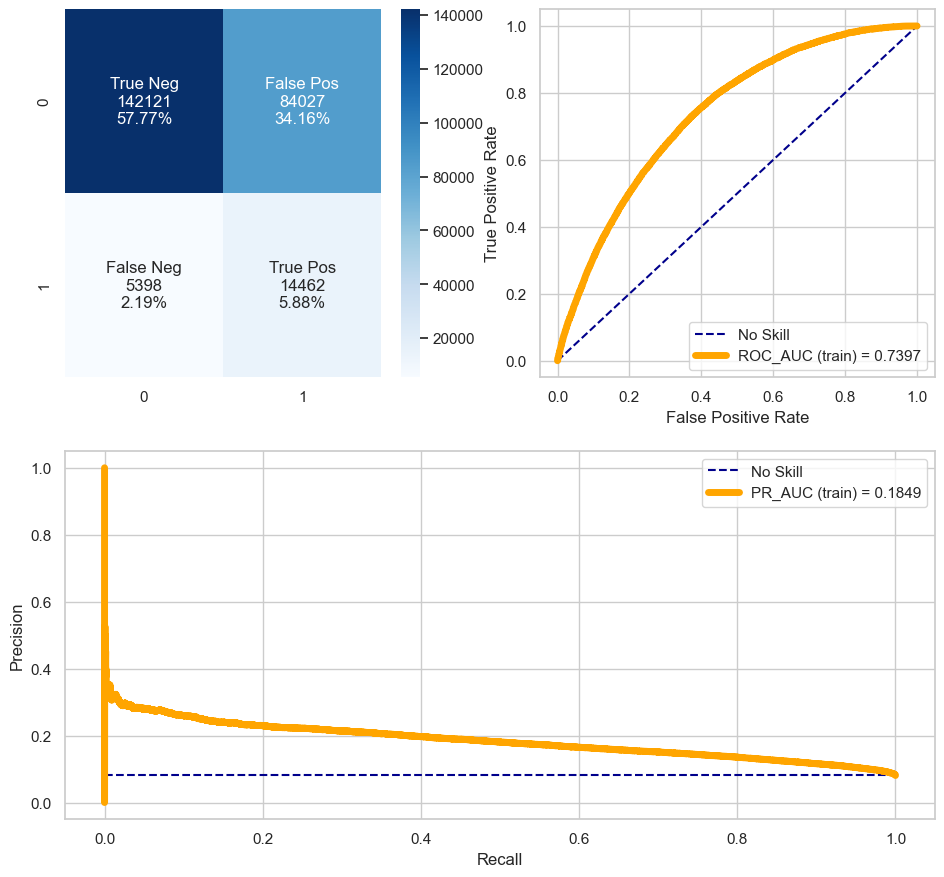

In [130]:
cf_matrix_roc_auc(grid, y_train, y_pred1, y_pred_proba1, "train")

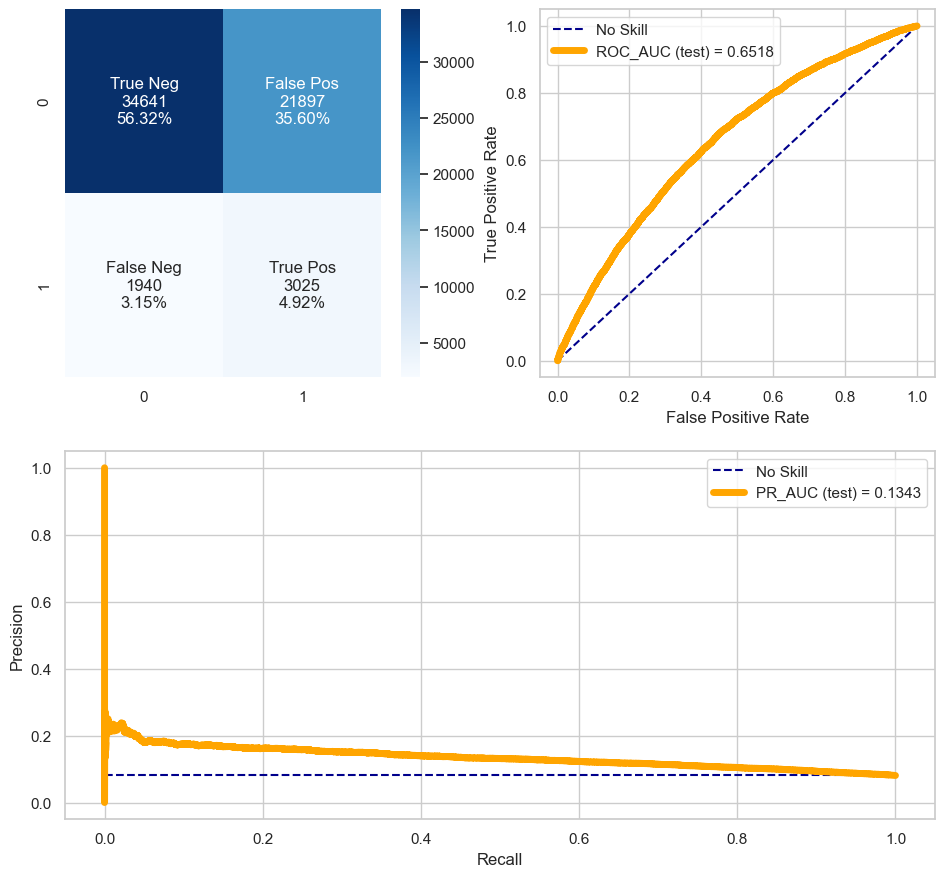

In [107]:
cf_matrix_roc_auc(grid, y_test, y_pred2, y_pred_proba2, "test")

In [108]:
# Mise à jour des résultats / Train
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='RandFor'),'Custom_score'] = round(custom_metric1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='RandFor'),'ROC_AUC'] = round(roc_auc1,4)

# Mise à jour des résultats / Test
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='RandFor'),'Custom_score'] = round(custom_metric2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='RandFor'),'ROC_AUC'] = round(roc_auc2,4)

In [109]:
#On conserve ces résultats pour un graphique comparatif
RandFor_y_pred1, RandFor_y_pred_proba1, RandFor_y_pred2, RandFor_y_pred_proba2, RandFor_roc_auc1, RandFor_roc_auc2=\
y_pred1, y_pred_proba1, y_pred2, y_pred_proba2, roc_auc1, roc_auc2

In [110]:
model_scores

,Data,Model,Custom_score,ROC_AUC,PR_AUC
0,Train,Dummy,0.8073,0.5,
1,Test,Dummy,0.8073,0.5,
2,Train,LogReg,0.5384,0.7508,
3,Test,LogReg,0.5374,0.7503,
4,Train,RandFor,0.561,0.7397,
5,Test,RandFor,0.6715,0.6518,
6,Train,XGBC,,,
7,Test,XGBC,,,


In [111]:
grid.best_estimator_

Pipeline(steps=[('impute', SimpleImputer()), ('smote', SMOTE(random_state=42)),
                ('scaler', StandardScaler()),
                ['classifier',
                 RandomForestClassifier(min_samples_leaf=50, n_estimators=3,
                                        random_state=42)]])

In [112]:
joblib.dump(grid.best_estimator_, 'Models/best_model_RandFor.joblib')
# model = joblib.load('Models/best_model_RandFor.joblib') to load it back

['Models/best_model_RandFor.joblib']

In [113]:
joblib.dump(best_thresh, 'Models/best_thresh_RandFor.joblib')
# best_thresh = joblib.load('Models/best_thresh_RandFor.joblib') to load it back

['Models/best_thresh_RandFor.joblib']

#### XGB Classifier

In [114]:
model = imbpipeline(steps = [["impute", SimpleImputer(missing_values=np.nan, strategy='mean')],
                             ['smote', SMOTE(random_state=42)],
                             ['scaler', StandardScaler()],
                             ['classifier', XGBClassifier(random_state=42)]])

In [115]:
model

Pipeline(steps=[['impute', SimpleImputer()], ['smote', SMOTE(random_state=42)],
                ['scaler', StandardScaler()],
                ['classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...)]])

In [116]:
import mlflow
# Définition d'une expérience (Une expérience peut contenir plusieurs *runs*)
mlflow.set_experiment("XGBClassifier")
mlflow.sklearn.autolog() # Ici on fait appel à l'API MLflow qui intégre les algos de Scikit-Learn.
                        # C'est grâce à ce code qu'on enregistre toutes les métriques et métadonnées de cette expérience (Module MLflow Tracking)
with mlflow.start_run(run_name = 'XGBClassifier'):
  clf4 = XGBClassifier()
  clf4.fit(X_train, y_train)
  # Effectuer les prédictions sur les données de test
  y_pred3 = clf4.predict(X_test)
  y_pred_proba4 = clf4.predict_proba(X_train)[:, 1]

In [117]:
# Set hyperparamteters range

# how quickly the model fits the residual errors
# by using additional base learners
learning_rate = [0.001, 0.01, 0.05, 0.1, 0.2]

# how deep the tree's decision nodes can go. 
# Must be a positive integer
max_depth = [2, 3, 5]

# fraction of the training set that can be used to train each tree.
# too low = underfitting / too high = overfitting
subsample = [0.5, 0.7, 0.9]

# fraction of the features that can be used to train each tree
colsample_bytree = [0.5, 0.95, 0.99]

In [118]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)

In [119]:
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    scoring=scores,
                    cv=stratified_kfold,
                    refit='custom_score',
                    verbose=2,
                    return_train_score=True,
                    n_jobs=1)

In [120]:
grid.fit(X_train, y_train)

2023/07/20 16:17:44 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4c6f046295cc4aa081178c201439aa52', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/07/20 16:17:45 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[['impute', SimpleImputer()], ['smote', SMOTE(random_state=42)],
                ['scaler', StandardScaler()],
                ['classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=No...`


Fitting 3 folds for each of 15 candidates, totalling 45 fits
[16:17:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf" } are not used.

[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=3; total time=   8.1s
[16:18:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf" } are not used.

[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=3; total time=   7.3s
[16:18:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf" } are not used.

[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifi

[16:21:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf" } are not used.

[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=50, classifier__n_estimators=6; total time=   9.4s
[16:22:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf" } are not used.

[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=50, classifier__n_estimators=6; total time=   9.3s
[16:22:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf" } are not used.

[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=50, classifier__n_estimators=7; total time=  10.1s
[16:22:23] WARNING: /U

2023/07/20 16:25:26 INFO mlflow.sklearn.utils: Logging the 5 best runs, 10 runs will be omitted.
2023/07/20 16:25:26 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[['impute', SimpleImputer()], ['smote', SMOTE(random_state=42)], ['scaler', StandardScaler()], ['classifier', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None,...`
2023/07/20 16:25:26 WARNING mlflow.utils: Truncated the value of the key `classifier`. Truncated value: `XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
         

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[['impute', SimpleImputer()],
                                       ['smote', SMOTE(random_state=42)],
                                       ['scaler', StandardScaler()],
                                       ['classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=No...
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=42, ...)]]),
             n_jobs=1,
             param_grid={'classifier__max_features': ['sqrt'],
                         'classifier__min_samples_leaf': [45, 50, 55],
                         'classifier__n_estimators': [3, 4, 5, 6, 7]},
             refit='custom_score', return_train_score=True,
             scoring={'custom_score': make_scorer(custom_metric, greater_is_better=False)},
             verbose=2)

In [43]:
import joblib 
# Backup X_train
joblib.dump(X_train, 'Models/X_train.pkl')

# Backup y_train
joblib.dump(y_train, 'Models/y_train.pkl')

['Models/y_train.pkl']

In [121]:
print('AUC_train : %0.4f' % roc_auc1)
print('custom_score_train : %0.4f' % custom_metric1)
print(classification_report(y_train, y_pred1))

AUC_train : 0.7397
custom_score_train : 0.5610
              precision    recall  f1-score   support

           0       0.96      0.63      0.76    226148
           1       0.15      0.73      0.24     19860

    accuracy                           0.64    246008
   macro avg       0.56      0.68      0.50    246008
weighted avg       0.90      0.64      0.72    246008



In [122]:
# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba2 = grid.predict_proba(X_test)[:, 1]

# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
# y_pred2 = grid.predict(X_test)
y_pred2 = grid.predict_proba(X_test)[:, 1]>best_thresh

roc_auc2 = roc_auc_score(y_test, y_pred_proba2)
# Measure of the custom_score from truthful and predicted values
custom_metric2 = custom_metric(y_test, y_pred2)

In [123]:
print('AUC_test : %0.4f' % roc_auc2)
print('custom_score_test : %0.4f' % custom_metric2)
print(classification_report(y_test, y_pred2))

AUC_test : 0.6763
custom_score_test : 0.9193
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     56538
           1       0.08      1.00      0.15      4965

    accuracy                           0.08     61503
   macro avg       0.04      0.50      0.07     61503
weighted avg       0.01      0.08      0.01     61503



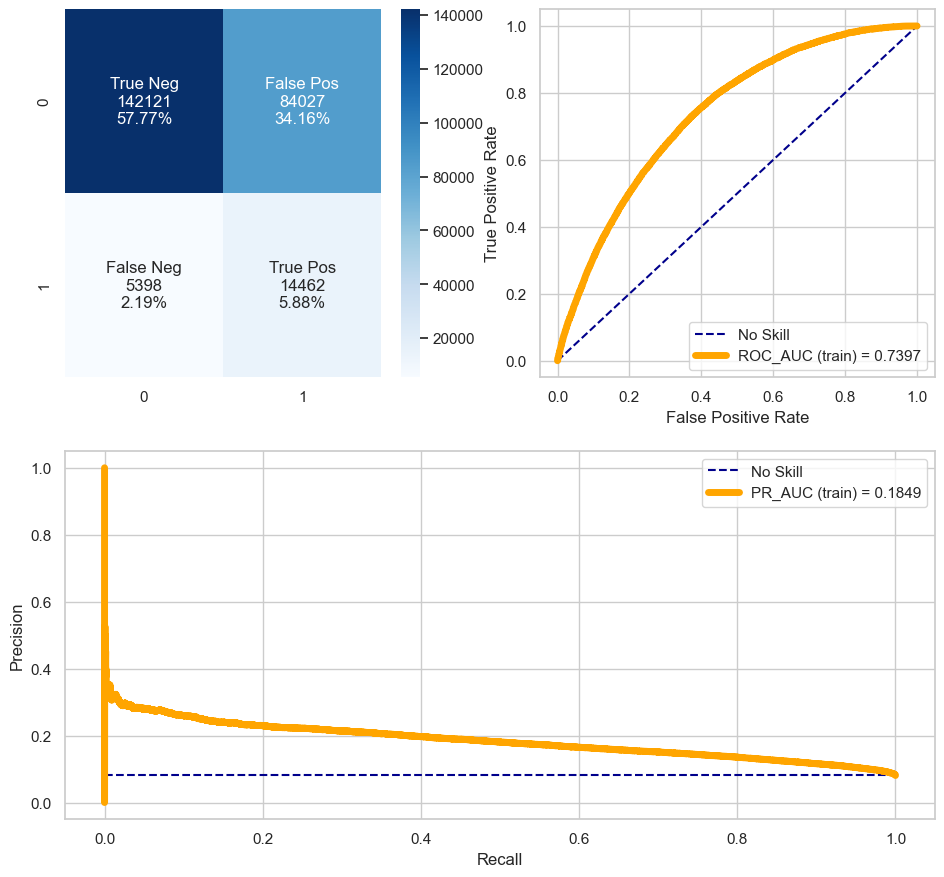

In [124]:
cf_matrix_roc_auc(grid, y_train, y_pred1, y_pred_proba1, "train")

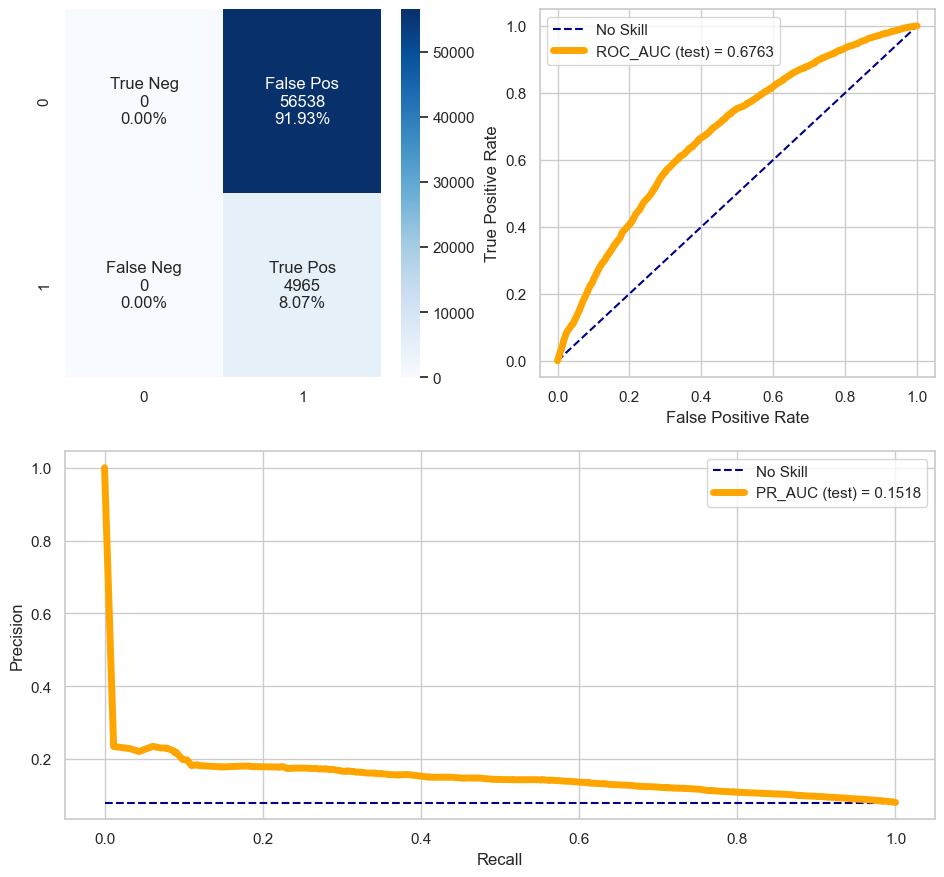

In [125]:
cf_matrix_roc_auc(grid, y_test, y_pred2, y_pred_proba2, "test")

In [126]:
# Mise à jour des résultats / Train
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='XGBC'),'Custom_score'] = round(custom_metric1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='XGBC'),'ROC_AUC'] = round(roc_auc1,4)

# Mise à jour des résultats / Test
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='XGBC'),'Custom_score'] = round(custom_metric2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='XGBC'),'ROC_AUC'] = round(roc_auc2,4)

In [127]:
# On conserve ces résultats pour un graphique comparatif
XGBC_y_pred1, XGBC_y_pred_proba1, XGBC_y_pred2, XGBC_y_pred_proba2, XGBC_roc_auc1, XGBC_roc_auc2=\
y_pred1, y_pred_proba1, y_pred2, y_pred_proba2, roc_auc1, roc_auc2

In [131]:
model_scores

,Data,Model,Custom_score,ROC_AUC,PR_AUC
0,Train,Dummy,0.8073,0.5,
1,Test,Dummy,0.8073,0.5,
2,Train,LogReg,0.5384,0.7508,
3,Test,LogReg,0.5374,0.7503,
4,Train,RandFor,0.561,0.7397,
5,Test,RandFor,0.6715,0.6518,
6,Train,XGBC,0.561,0.7397,
7,Test,XGBC,0.9193,0.6763,


In [132]:
grid.best_estimator_

Pipeline(steps=[('impute', SimpleImputer()), ('smote', SMOTE(random_state=42)),
                ('scaler', StandardScaler()),
                ['classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=N...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_features='sqrt',
                               max_leaves=None, min_child_weight=None,
                               min_samples_leaf=45, missing=nan,
                               monotone_constraints=None, n_estimators=3,
                               n_jobs=None, num_parallel_tree=None, ...)]])

In [133]:
joblib.dump(grid.best_estimator_, 'Models/best_model_XGBC.joblib')
# model = joblib.load('Models/best_model_XGBC.joblib') to load it back

['Models/best_model_XGBC.joblib']

In [134]:
joblib.dump(best_thresh, 'Models/best_thresh_XGBC.joblib')
# best_thresh = joblib.load('Models/best_thresh_XGBC.joblib') to load it back

['Models/best_thresh_XGBC.joblib']

### Selecting best model

In [135]:
pred_proba_1 = [Dummy_y_pred_proba1, LogReg_y_pred_proba1, RandFor_y_pred_proba1,\
                XGBC_y_pred_proba1]

In [136]:
pred_proba_2 = [Dummy_y_pred_proba2, LogReg_y_pred_proba2, RandFor_y_pred_proba2,\
                XGBC_y_pred_proba2]

In [137]:
predictions_1 = [Dummy_y_pred1, LogReg_y_pred1, RandFor_y_pred1,\
                 XGBC_y_pred1]

In [138]:
predictions_2 = [Dummy_y_pred2, LogReg_y_pred2, RandFor_y_pred2,\
                 XGBC_y_pred2]

In [139]:
roc_auc_1 = [Dummy_roc_auc1, LogReg_roc_auc1, RandFor_roc_auc1,\
             XGBC_roc_auc1]

In [140]:
roc_auc_2 = [Dummy_roc_auc2, LogReg_roc_auc2, RandFor_roc_auc2,\
             XGBC_roc_auc2]

- Confusion Matrix

In [141]:
print(f"Le jeu d'entrainement comporte {sum(y_train==1)} \"Default\" pour {sum(y_train==0)} \"No Default\"")

Le jeu d'entrainement comporte 19860 "Default" pour 226148 "No Default"


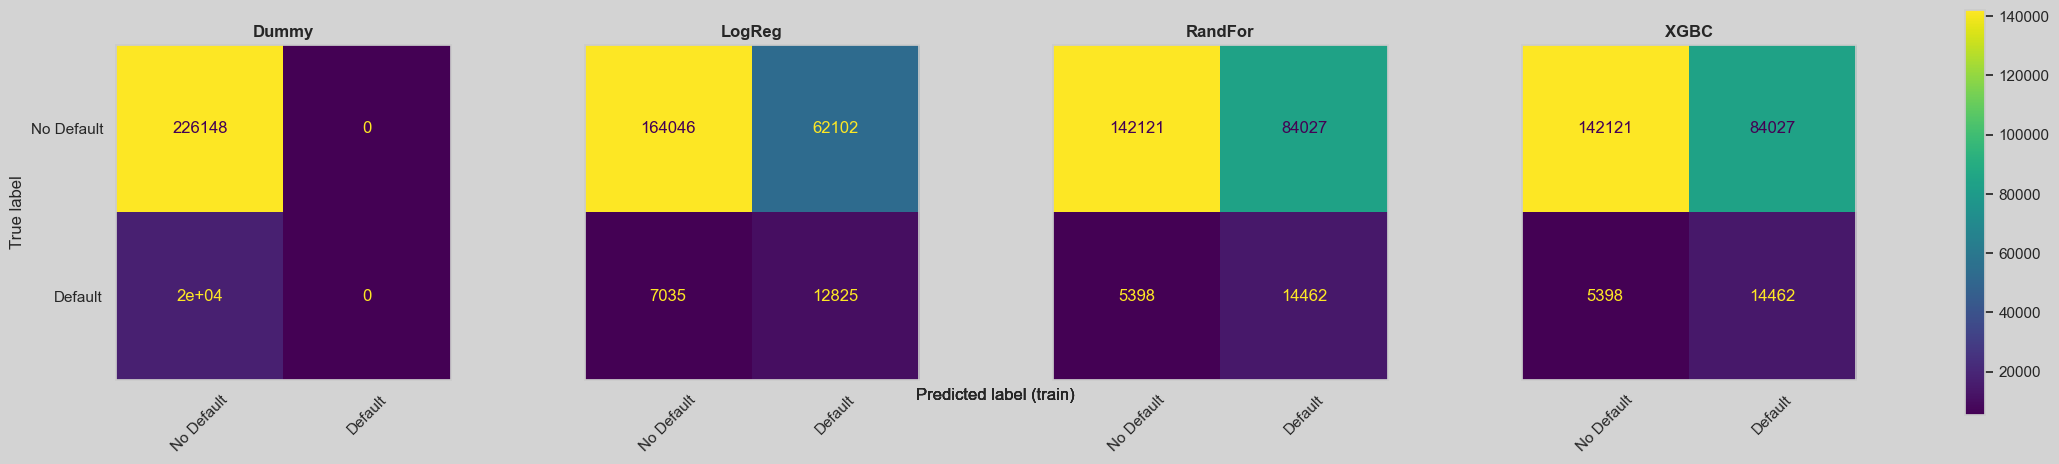

In [142]:
cf_matrix_compare("train")

In [143]:
print(f"Le jeu de test comporte {sum(y_test==1)} \"Default\" pour {sum(y_test==0)} \"No Default\"")

Le jeu de test comporte 4965 "Default" pour 56538 "No Default"


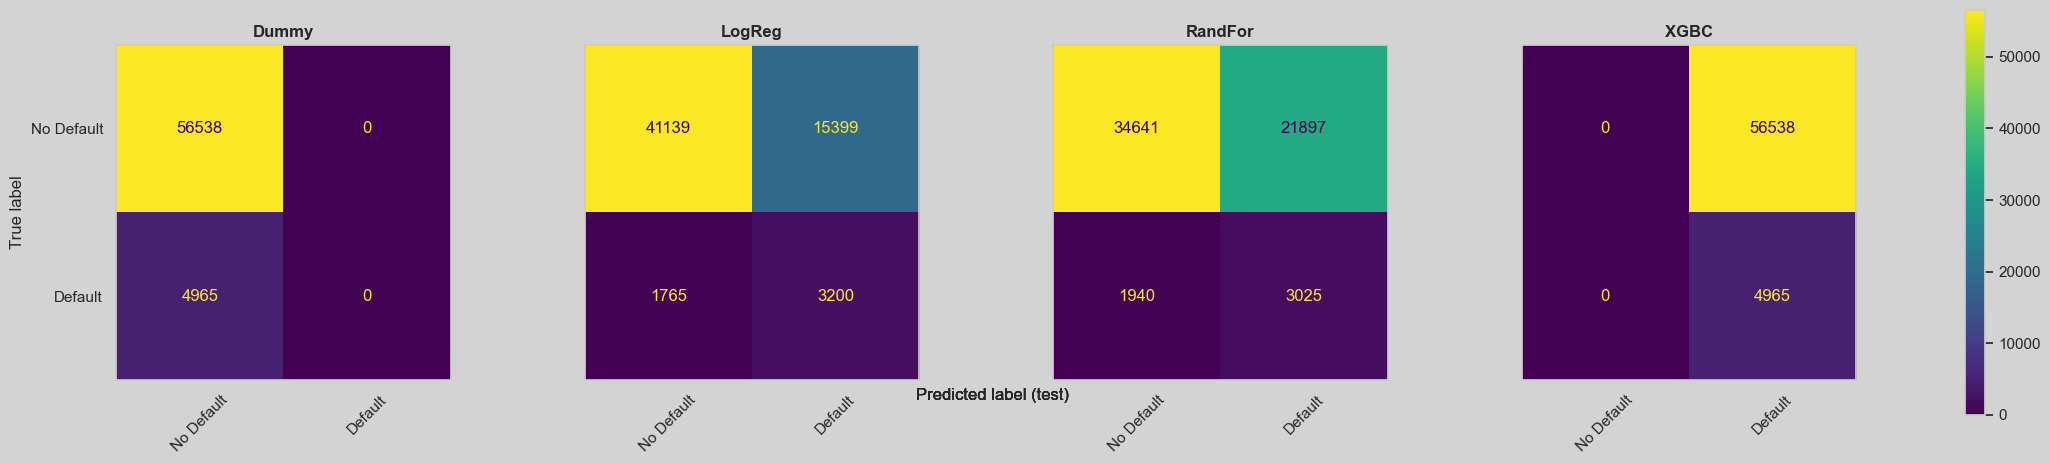

In [144]:
cf_matrix_compare("test")

- ROC and PR Curves

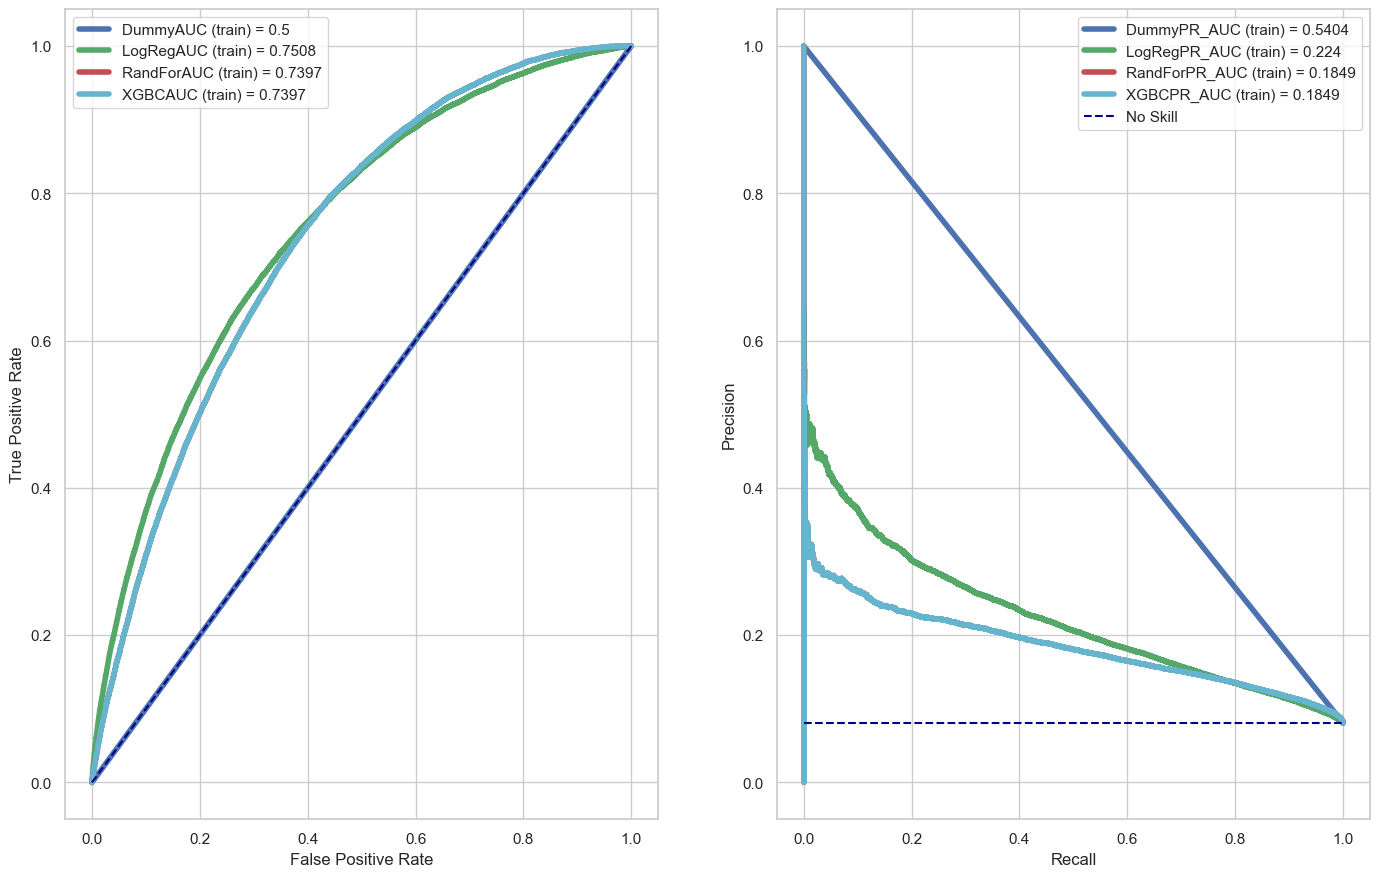

In [145]:
pr_auc_train = auc_compare("train")[0]

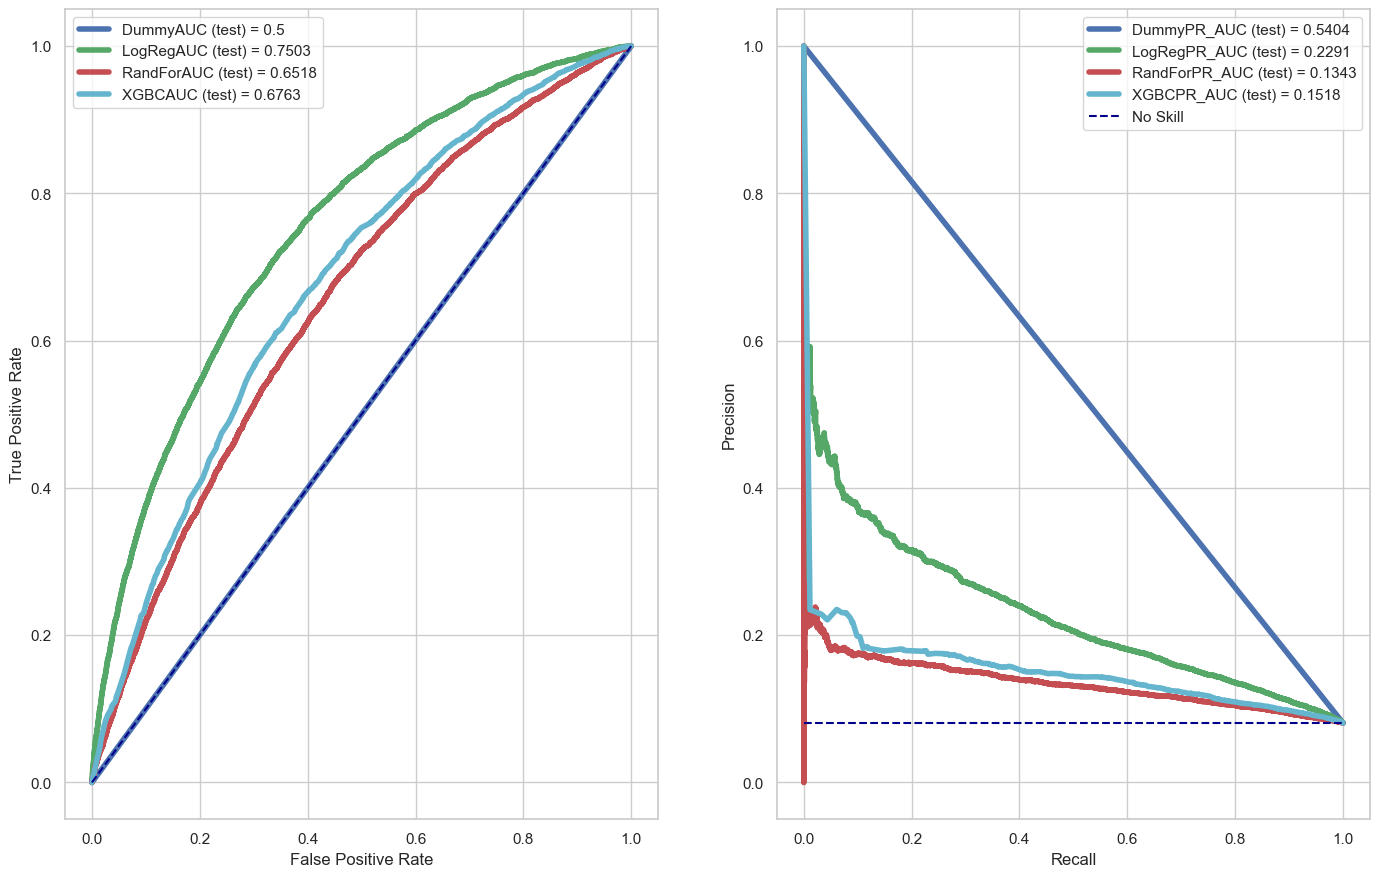

In [146]:
pr_auc_test = auc_compare("test")[1]

In [147]:
pr_auc_dict_train= {'Data':'Train', 'Model':model_names, 'PR_AUC':pr_auc_train}
pr_auc_dict_test= {'Data':'Test', 'Model':model_names, 'PR_AUC':pr_auc_test}

In [148]:
# Adding PR_AUC results to the final dataframe
df_auc_train = pd.DataFrame.from_dict(pr_auc_dict_train)
df_auc_test = pd.DataFrame.from_dict(pr_auc_dict_test)
df_auc_tot = pd.concat([df_auc_train, df_auc_test], axis=0)
model_scores_m = pd.merge(model_scores, df_auc_tot, how='left', on=['Data', 'Model'], suffixes=('_x', None))
model_scores_m.drop(columns='PR_AUC_x', inplace=True)
model_scores = model_scores_m

In [149]:
model_scores

,Data,Model,Custom_score,ROC_AUC,PR_AUC
0,Train,Dummy,0.8073,0.5,0.540365
1,Test,Dummy,0.8073,0.5,0.540364
2,Train,LogReg,0.5384,0.7508,0.223985
3,Test,LogReg,0.5374,0.7503,0.229102
4,Train,RandFor,0.561,0.7397,0.184874
5,Test,RandFor,0.6715,0.6518,0.134322
6,Train,XGBC,0.561,0.7397,0.184874
7,Test,XGBC,0.9193,0.6763,0.151798


#### FEATURES IMPORTANTS

In [150]:
import joblib

# Charger le pipeline à partir du fichier enregistré
pipeline = joblib.load('Models/best_model_XGBC.joblib')

# Afficher les noms des étapes du pipeline
print(pipeline.named_steps.keys())

dict_keys(['impute', 'smote', 'scaler', 'classifier'])


In [151]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# Charger le pipeline à partir du fichier enregistré
pipeline = joblib.load('Models/best_model_XGBC.joblib')

# Accéder au modèle dans le pipeline
model = pipeline.named_steps['classifier']

# Accéder aux caractéristiques importantes du modèle
feature_importances = model.feature_importances_

# Feature importances
feat_name = train_set.drop(['SK_ID_CURR', 'TARGET'], axis=1).columns
feat_valu = feature_importances[:len(feat_name)]  # Ajustement de la longueur

feat_frame = pd.DataFrame()
feat_frame['feature'] = feat_name
feat_frame['importance'] = feat_valu

In [152]:
def plot_feature_importances(df):
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

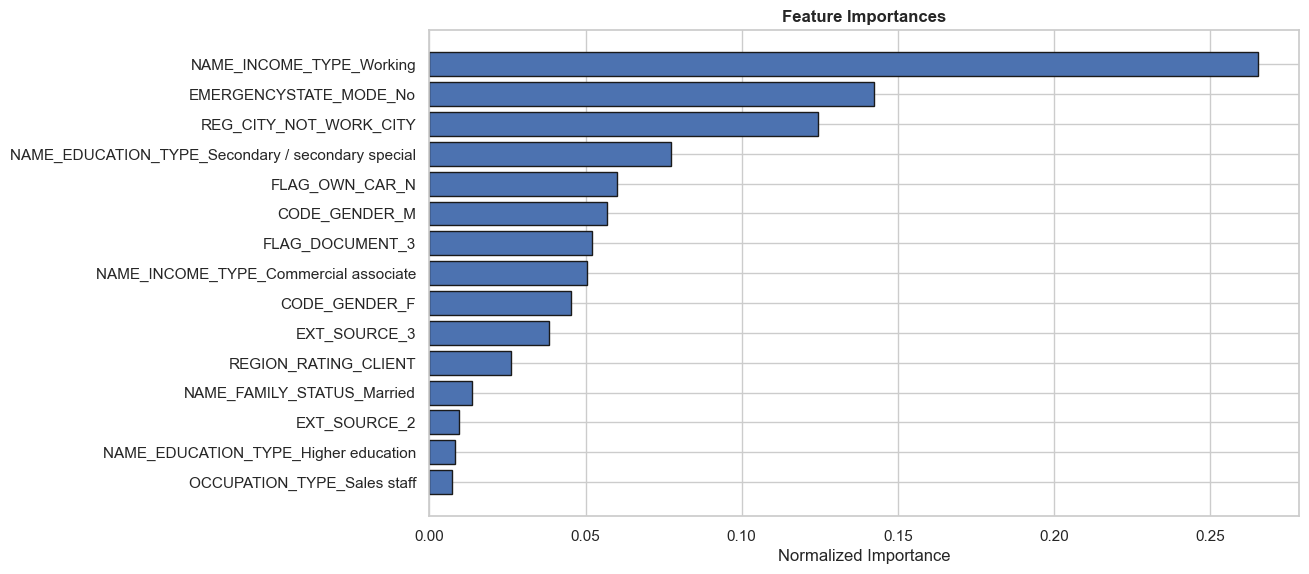

,index,feature,importance,importance_normalized
0,130,NAME_INCOME_TYPE_Working,0.265235,0.265235
1,244,EMERGENCYSTATE_MODE_No,0.142280,0.142280
2,25,REG_CITY_NOT_WORK_CITY,0.124304,0.124304
3,135,NAME_EDUCATION_TYPE_Secondary / secondary special,0.077326,0.077326
4,113,FLAG_OWN_CAR_N,0.060222,0.060222
...,...,...,...,...
241,90,FLAG_DOCUMENT_14,0.000000,0.000000
242,91,FLAG_DOCUMENT_15,0.000000,0.000000
243,92,FLAG_DOCUMENT_16,0.000000,0.000000
244,93,FLAG_DOCUMENT_17,0.000000,0.000000


In [153]:
plot_feature_importances(feat_frame)

In [154]:
import joblib

# Charger le pipeline à partir du fichier enregistré
pipeline1 = joblib.load('Models/best_model_RandFor.joblib')

# Afficher les noms des étapes du pipeline
print(pipeline1.named_steps.keys())

dict_keys(['impute', 'smote', 'scaler', 'classifier'])


In [155]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# Charger le pipeline à partir du fichier enregistré
pipeline1 = joblib.load('Models/best_model_RandFor.joblib')

# Accéder au modèle dans le pipeline
model1 = pipeline1.named_steps['classifier']

# Accéder aux caractéristiques importantes du modèle
feature_importances1 = model1.feature_importances_

# Feature importances
feat_name1 = train_set.drop(['SK_ID_CURR', 'TARGET'], axis=1).columns
feat_valu1 = feature_importances[:len(feat_name)]  # Ajustement de la longueur

feat_frame1 = pd.DataFrame()
feat_frame1['featur'] = feat_name
feat_frame1['import'] = feat_valu

In [156]:
def plot_feature_importances(df):
    
    # Sort features according to importance
    df1 = df.sort_values('import', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df1['import_normalized'] = df1['import'] / df1['import'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df1['import_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['featur'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df1

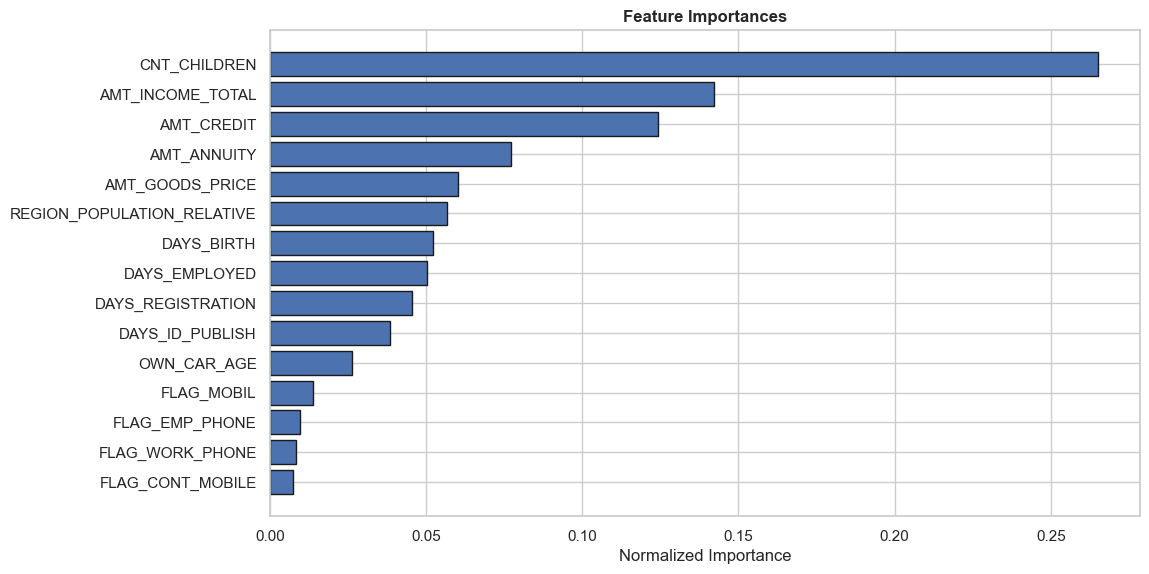

,index,featur,import,import_normalized
0,130,NAME_INCOME_TYPE_Working,0.265235,0.265235
1,244,EMERGENCYSTATE_MODE_No,0.142280,0.142280
2,25,REG_CITY_NOT_WORK_CITY,0.124304,0.124304
3,135,NAME_EDUCATION_TYPE_Secondary / secondary special,0.077326,0.077326
4,113,FLAG_OWN_CAR_N,0.060222,0.060222
...,...,...,...,...
241,90,FLAG_DOCUMENT_14,0.000000,0.000000
242,91,FLAG_DOCUMENT_15,0.000000,0.000000
243,92,FLAG_DOCUMENT_16,0.000000,0.000000
244,93,FLAG_DOCUMENT_17,0.000000,0.000000


In [157]:
plot_feature_importances(feat_frame1)

In [158]:
from pyngrok import ngrok
# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2RCxEgHpK48lY49uTDNen9FUk4P_3WAoBceG5nP9BHXBrK2Na" 
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

t=2023-07-20T16:54:49+0200 lvl=warn msg="ngrok config file found at legacy location, move to XDG location" xdg_path="/Users/sbeddyy/Library/Application Support/ngrok/ngrok.yml" legacy_path=/Users/sbeddyy/.ngrok2/ngrok.yml


MLflow Tracking UI: https://1669-176-149-136-233.ngrok-free.app


In [163]:
!mlflow ui

Traceback (most recent call last):
  File "/Users/sbeddyy/anaconda3/bin/mlflow", line 5, in <module>
    from mlflow.cli import cli
  File "/Users/sbeddyy/anaconda3/lib/python3.10/site-packages/mlflow/__init__.py", line 41, in <module>
    from mlflow import projects  # pylint: disable=unused-import
  File "/Users/sbeddyy/anaconda3/lib/python3.10/site-packages/mlflow/projects/__init__.py", line 9, in <module>
    import mlflow.projects.databricks
  File "/Users/sbeddyy/anaconda3/lib/python3.10/site-packages/mlflow/projects/databricks.py", line 11, in <module>
    from mlflow import tracking
  File "/Users/sbeddyy/anaconda3/lib/python3.10/site-packages/mlflow/tracking/__init__.py", line 8, in <module>
    from mlflow.tracking.client import MlflowClient
  File "/Users/sbeddyy/anaconda3/lib/python3.10/site-packages/mlflow/tracking/client.py", line 28, in <module>
    from mlflow.tracking._model_registry.client import ModelRegistryClient
  File "/Users/sbeddyy/anaconda3/lib/python3.10/site